# Hyper-personalization Through Product Reviews: Exploring New Market Opportunites

A multi-modal approach to generating user recommendations.

## Import Libraries and Define File Paths

In [1]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode
import uuid

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Define Utility Functions and Dataset Generation Functions

In [2]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data in json_data:
        product = {}
        if ('body' not in product_data or 'reviews' not in product_data['body']
            or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_name = product_data['body'].get('name', 'Unknown Product')
        product_data = product_data['body']
        asin = product_data['canonicalUrl'].split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0:
            continue
        
        ignore = ['dimensions', 'country_of_origin', 'batteries_included',
                  'weight', 'height', 'size', 'model', 'manufacturer',
                  'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                  'capacity', 'number_of_items', 'import', 'lxwxh', 'product'
                  'included']

        product['ASIN'] = asin

        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name
            })
            asins.append(asin)
        breadcrumbs = product_data.get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            for ig in ignore:
                if ig in name:
                    flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        
        products.append(product)

        review = {}
        for r in reviews_data:
            review['ASIN'] = asin
            review['ProductName'] = clean_str(product_name)
            reviewer_link = r['reviewerLink'].split('/')[-1].split('.')[-1]
            if len(reviewer_link) < 1:
                reviewer_link = str(uuid.uuid4())
            review['reviewerID'] = r['reviewerName'] + '_' + reviewer_link
            review['price'] = product_data.get('rawPrice', 0)
            reviewRating = re.findall(r'(\d+\.\d+)', r['reviewRating'])
            reviewLocation = r['reviewDate'].split('on')[0].split(' in ')[-1].replace('the ', '')
            reviewDate = re.findall(r'on (.+)$', r['reviewDate'])
            reviewVotes = re.findall(r'(\d+)', r['reviewVotes'])
            review['image'] = product_data.get('mainImage', None)
            
            if reviewRating:
                review['customerReview'] = float(reviewRating[0])
            else:
                review['customerReview'] = np.nan
            if reviewDate:
                review['reviewDate'] = reviewDate[0]
            else:
                review['reviewDate'] = 'Unknown'
            if reviewLocation:
                review['reviewLocation'] = reviewLocation
            else:
                review['reviewLocation'] = 'Unknown'
            if reviewVotes:
                review['reviewVotes'] = reviewVotes[0]
            else:
                review['reviewVotes'] = 0
            reviews.append(review)
            review = {}
    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [3]:
all_json_data = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_reviews_df.to_csv(f"{dir}/reviews.csv")
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in monitor:   0%|          | 0/202 [00:00<?, ?it/s]

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 5411.60it/s]


Error loading JSON from file ../dataset/extracts/amazon/stove/items/amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 4397.60it/s]


### Preprocess itemset

In [4]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [5]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 5]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby('reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

## Load Dataset

In [6]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [7]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

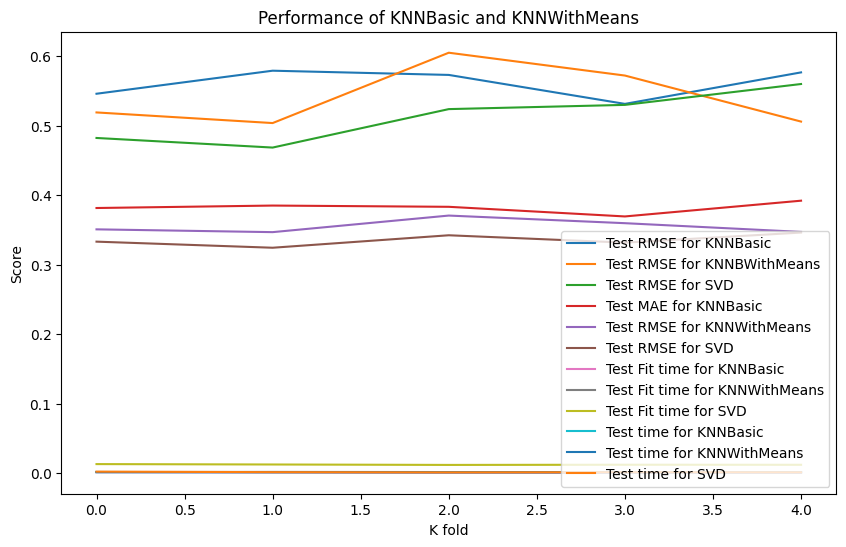

In [8]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

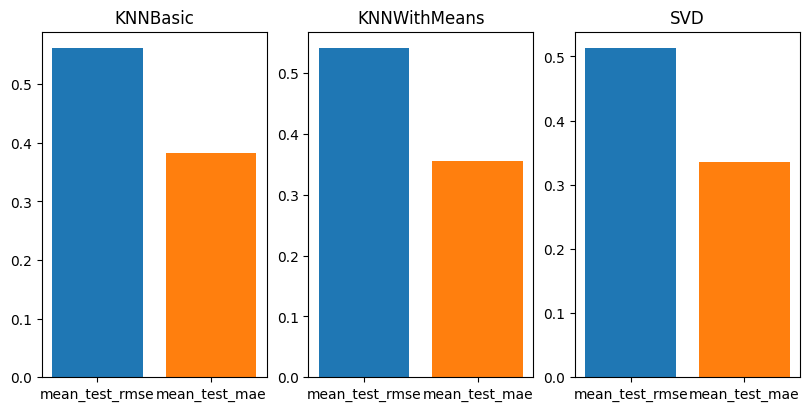

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### NDCG, Precision, and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py and https://github.com/NicolasHug/Surprise/issues/339

In [10]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

def get_ndcg(surprise_predictions, k_highest_scores=None):
    """ 
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all. 
  
    Returns: 
    float in [0., 1.]: The averaged NDCG scores over all recommendations
  
    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse
    
    uids = []
    iids = []
    uid_mapping = {}
    iid_mapping = {}

    iter = 0
    for s in surprise_predictions:
        if s.uid in uid_mapping:
            uids.append(uid_mapping[s.uid])
        else:
            uid_mapping[s.uid] = iter
            uids.append(iter)

        if s.iid in iid_mapping:
            iids.append(iid_mapping[s.iid])
        else:
            iid_mapping[s.iid] = iter
            iids.append(iter)

        iter += 1

    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]
    
    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )    
    
    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )
    
    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()
    
    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores)

algo_res = {}
method = ["KNNBasic", "KNNWithMeans", "SVD"]
iter = 0
for algo in algos:
    res_dict = {'precision': [], 'recall': [], 'ndcg': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)
        ndcgs = get_ndcg(predictions, 5)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
        res_dict['ndcg'].append(ndcgs)
    algo_res[method[iter]] = res_dict
    iter += 1

df_metrics_surprise = pd.DataFrame.from_dict({(i,j): algo_res[i][j] 
                           for i in algo_res.keys() 
                           for j in algo_res[i].keys()},
                       orient='index', columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
df_metrics_surprise['average'] = df_metrics_surprise.apply(pd.Series.mean, axis=1)
display(df_metrics_surprise)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
"(KNNBasic, precision)",0.965952,0.976583,0.946387,0.972711,0.965952,0.965517
"(KNNBasic, recall)",0.985714,0.989247,0.963287,0.985348,0.985714,0.981862
"(KNNBasic, ndcg)",0.555550,0.554249,0.566903,0.542820,0.567220,0.557349
"(KNNWithMeans, precision)",0.968531,0.952166,0.967145,0.968937,0.959677,0.963291
"(KNNWithMeans, recall)",0.981352,0.971119,0.971924,0.976703,0.970131,0.974246
"(KNNWithMeans, ndcg)",0.574653,0.552211,0.553785,0.553537,0.554474,0.557732
"(SVD, precision)",0.969753,0.962234,0.965480,0.960132,0.958788,0.963277
"(SVD, recall)",0.985185,0.971631,0.975089,0.974820,0.978182,0.976981
"(SVD, ndcg)",0.544105,0.558965,0.557919,0.555051,0.546962,0.552601


### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [11]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
algo_names = ['KNNBasic', 'KNNWithMeans', 'SVD']
recommendations_surprise = {'KNNBasic': {}, 'KNNWithMeans': {}, 'SVD': {}}
iter = 0
for algo in algos:
    trainset, testset = train_test_split_surprise(dataset, test_size=1.0)
    predictions = algo.test(testset)
    top_n = get_top_n(predictions, n=10)
    for uid, user_ratings in top_n.items():
        recommendations_surprise[algo_names[iter]][uid] = [iid for (iid, _) in user_ratings]
    iter += 1

### Pick out users and explore their history and recommendations

In [12]:
def get_random_users(lst, n):
    rand_ids = random.sample(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs


userids = get_random_users(
    list(recommendations_surprise['SVD'].keys()),
    len(list(recommendations_surprise['SVD'].keys()))
)
userids_ilocs = get_ilocs(df_utility, userids)

## Latent-factor based Collaborative Filtering

### ALS

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


100%|██████████| 244/244 [00:00<00:00, 3414.11it/s]


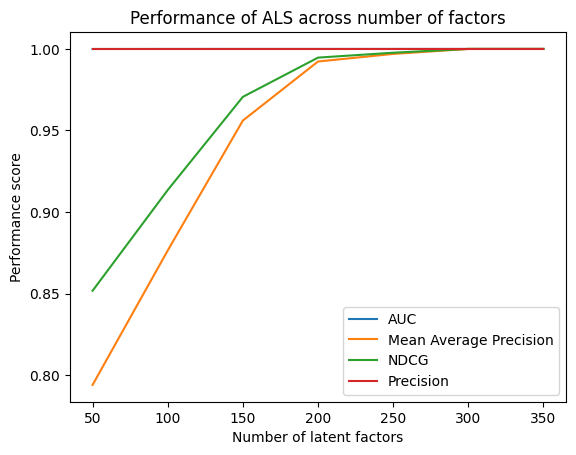

In [13]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
#!export OPENBLAS_NUM_THREADS=1
#threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [14]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

auc = AUC_at_k(model,training_set,test_set,
            K=len(df_utility), show_progress=True)
ndcg_als = ndcg_at_k(model, training_set, test_set,
            K=len(df_utility), show_progress=True)
precision = precision_at_k(model, training_set,
            test_set, K=len(df_utility), show_progress=True)

print(f"AUC: {auc}")
print(f"precision: {precision}")
print(f"ndcg: {ndcg_als}")

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations_als_ilocs = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

recommendations_als = {}
for user_ind, reco_ids, scores in recommendations_als_ilocs:
    recos = {}
    reviewer_id = df_utility.iloc[user_ind, :].name
    reco_ids = df_utility.columns[reco_ids]
    n = 0
    for i in range(len(reco_ids)):
        recos[reco_ids[i]] = scores[i]
        n += 1
        if n == 9: break
    recommendations_als[reviewer_id]  = recos

100%|██████████| 244/244 [00:00<00:00, 3939.12it/s]


AUC: 0.999999633081203
precision: 1.0
ndcg: 0.997666707205219


## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [29]:
def get_user_profile(user_ratings_nonzero, items_df):
    """
    Return series representing aggregated user profile
    """
    nonzero_asins = user_ratings_nonzero.index.tolist()
    user_profile = items_df.mul(user_ratings_nonzero, axis=0).sum(
        axis=0) / user_ratings_nonzero.notna().sum()
    return user_profile, nonzero_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    if dist == 'euc':
        rev = False
    if dist == 'cos' or dist == 'jac':
        rev = True
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=rev)[:n])
    return sorted_similarites


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    dcg_list = []
    idcg_list = []
    ndcg_list = []
    iter = 0
    for user in userids:
        user_ratings = df_utility.loc[user]
        user_ratings_nonzero = user_ratings[user_ratings > 0]
        user_profile, nonzero_asins = get_user_profile(user_ratings_nonzero, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        print(f"generating recos for {user} | {iter}")
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonzero_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        #df_reco = asins_df.loc[list(recos.keys())]
        #display(df_reco)
        recommendations[user] = recos
        iter += 1
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
    return recommendations, ndcg_list

## Evaluation: NDCG @ K

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [31]:
np.seterr(invalid='ignore')
ndcg_content = {}
items_df, df_utility, reviews_df, asins_df = load_dataset()
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
recommendations_content = {}
try:
    items_df.drop(['level_0'], inplace=True, axis=1)
except:
    pass
try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass
try:
    asins_df.set_index('ASIN', inplace=True)
except:
    pass

# evaluate ndcg
recommendations, ndcg_list = basic_content_based_recommender(
    userids, df_utility, items_df.copy(),
    reviews_df, 10, True, 'euc')
ave_ndcg = np.mean(ndcg_list)
print(f"average ndcg with distance metric euc is {ave_ndcg}")

# generate actual recommendations
recommendations_content['euc'], _ = basic_content_based_recommender(
    userids, df_utility, items_df.copy(),
    reviews_df, 10, False, 'euc')

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)
generating recos for Natalie_AETPO4LP3KPZHZW23BBVJCVG3RZA | 0
generating recos for Gabby Tess_AEUPPMQCYIKW44K7MX65ROTABNCQ | 1
generating recos for Vicky_AFHMUVCN752EYZ23R4VMXATYWXIQ | 2
generating recos for Lulu_AFXLAU5OVSMX5TMFB4SZJLX7ICLQ | 3
generating recos for Amazon Customer_AGJCNG6RYPJAKUEDVTLF2SS35RBQ | 4
generating recos for Clarence Novak_AFU57QJCYMYMATLZIUBRYMJ3G2UQ | 5
generating recos for samantha_AEMXIMF35Q27VDG4QBMFCPITJ4WQ | 6
generating recos for Diego Degaudenzi_AE2WMLVMOCBSPZLBJ4JGUQWTUCTA | 7
generating recos for scopin4u2_AESASIE4UT2JCTJEZATLGJNV6NFA | 8
generating recos for Placeholder_AFOHPTH35IN37CU7FNS7IPKC774A | 9
generating recos for Bob B_AGHPMS5YVT74RENJNL5DOCNSL7PA | 10
generating recos for Michael_AGOFMGQZ5X3DUQXNOFWVXJIKP3JA | 11
generating recos for Naomi_AEMTCT7G6YRMOJ7FNZNWZ5F35YLA | 12
generating recos for Alex O_AEGT3SORHVNRHMHTO2BXTOXXQFXA | 13
generat

## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [32]:
items_df, df_utility, reviews_df, asins_df = load_dataset()
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
udf = melted_user_df

shape of df_utility: (378, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


In [33]:
dataset = LightFMDataset()
dataset.fit(users=udf['reviewerID'].unique(),
            items=udf['ASIN'].unique())

(interactions, _) = dataset.build_interactions(zip(udf['reviewerID'], 
                                                   udf['ASIN'],
                                                   udf['rating']))

In [34]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=50)
model.fit(Train, epochs=30, num_threads=1)

In [35]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Train: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s]

Train Results:
K = 1: AUC score: 0.9999611973762512, Precision: 0.9893617033958435, Recall: 0.21694028228759143
K = 2: AUC score: 0.9999611973762512, Precision: 0.9867021441459656, Recall: 0.4296843470810931
K = 3: AUC score: 0.9999611973762512, Precision: 0.978723406791687, Recall: 0.6320856222764858
K = 4: AUC score: 0.9999611973762512, Precision: 0.9434840679168701, Recall: 0.7922883159115949
K = 5: AUC score: 0.9999611973762512, Precision: 0.8680851459503174, Recall: 0.884671860610534
K = 6: AUC score: 0.9999611973762512, Precision: 0.7810284495353699, Recall: 0.9338361688721514
K = 7: AUC score: 0.9999611973762512, Precision: 0.6979483962059021, Recall: 0.9591339624427859
K = 8: AUC score: 0.9999611973762512, Precision: 0.6256648898124695, Recall: 0.9712288684754268
K = 9: AUC score: 0.9999611973762512, Precision: 0.5653073787689209, Recall: 0.9788911503945922
K = 10: AUC score: 0.9999611973762512, Precision: 0.5159574747085571, Recall: 0.9850221621654662


In [36]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Test: 100%|██████████| 10/10 [00:00<00:00, 23.56it/s]

Test Results:
K = 1: AUC score: 0.2877894341945648, Precision: 0.0035211266949772835, Recall: 0.0017605633802816902
K = 2: AUC score: 0.2877894341945648, Precision: 0.0017605633474886417, Recall: 0.0017605633802816902
K = 3: AUC score: 0.2877894341945648, Precision: 0.002347417874261737, Recall: 0.0035211267605633804
K = 4: AUC score: 0.2877894341945648, Precision: 0.0026408450212329626, Recall: 0.004694835680751174
K = 5: AUC score: 0.2877894341945648, Precision: 0.007042254321277142, Recall: 0.017018779342723004
K = 6: AUC score: 0.2877894341945648, Precision: 0.00880281813442707, Recall: 0.028755868544600938
K = 7: AUC score: 0.2877894341945648, Precision: 0.009054325520992279, Recall: 0.0346244131455399
K = 8: AUC score: 0.2877894341945648, Precision: 0.00836267601698637, Recall: 0.035798122065727696
K = 9: AUC score: 0.2877894341945648, Precision: 0.0074334898963570595, Recall: 0.035798122065727696
K = 10: AUC score: 0.2877894341945648, Precision: 0.007746479939669371, Recall: 0.0

In [45]:
def get_top_n_recommendations_with_latest_transactions(model, dataset, user_id, transactions_df, n=10):
    try:
        transactions_df.reset_index(inplace=True)
    except:
        pass

    # Generate predictions for all items for this user
    user_index = dataset.mapping()[0][user_id]
    
    # Retrieve the actual item indices from the dataset mapping
    item_indices = list(dataset.mapping()[2].values())  # This ensures you're using the correct item indices
    
    # Generate predictions using the correct item indices
    scores = model.predict(user_index, np.array(item_indices))
    
    # Map scores to item IDs
    reverse_item_map = {v: k for k, v in dataset.mapping()[2].items()}
    scored_items = [(score, reverse_item_map[i]) for score, i in zip(scores, item_indices)]
    
    # Proceed with filtering scores for latest items and ranking them as before
    latest_transactions = transactions_df[transactions_df['reviewerID'] == user_id]\
                            .sort_values('reviewDate', ascending=False)\
                            .head(10)
    latest_items = set(latest_transactions['ASIN'])
    latest_scores = [score for score in scored_items if score[1] in latest_items]
    latest_scores.sort(reverse=True, key=lambda x: x[0])  # Sort based on scores
    top_item_ids = [item for _, item in latest_scores[:n]]

    return top_item_ids

recommendations_lightfm = {}
for uid in userids:
    recommendations_lightfm[uid] = get_top_n_recommendations_with_latest_transactions(
        model, dataset, uid, reviews_df, n=10)

# Compare NDCG across algorithms

,NDCG
KNNBasic,0.557349
KNNWithMeans,0.557732
SVD,0.552601
ALS,0.997667
Content-based,0.979876


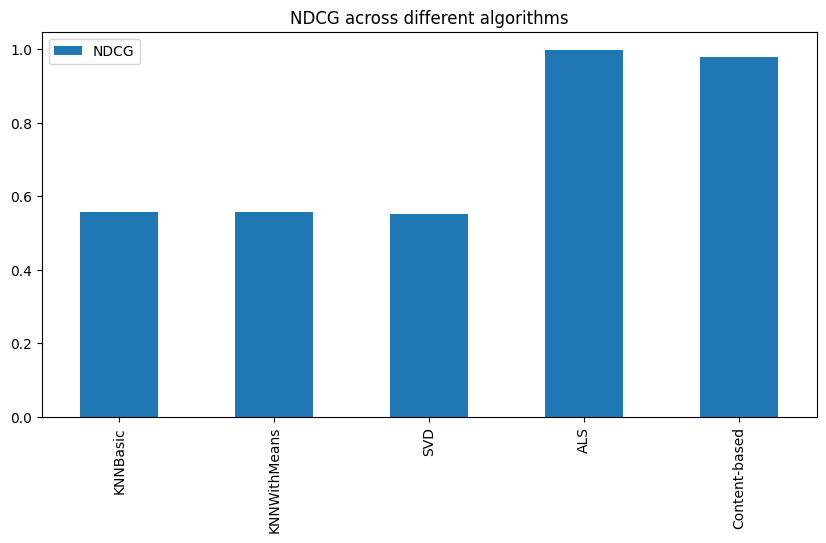

In [46]:
df_surprise_ndcg = df_metrics_surprise.loc[[
    ("KNNBasic", "ndcg"), ("KNNWithMeans", "ndcg"), ("SVD", "ndcg")
    ]]
df_surprise_ndcg.rename(index={
    ("KNNBasic", "ndcg"): "KNNBasic",
    ("KNNWithMeans", "ndcg"): "KNNWithMeans",
    ("SVD", "ndcg"): "SVD"
    }, inplace=True)
df_surprise_ndcg = df_surprise_ndcg["average"]

ndcg_dict = {
    "KNNBasic": df_surprise_ndcg.loc["KNNBasic"],
    "KNNWithMeans": df_surprise_ndcg.loc["KNNWithMeans"],
    "SVD": df_surprise_ndcg.loc["SVD"],
    "ALS": ndcg_als,
    "Content-based": ave_ndcg,
}

ndcg_df = pd.DataFrame.from_dict(ndcg_dict, orient="index")
ndcg_df.rename(columns={0: "NDCG"}, inplace=True)
display(ndcg_df)

ndcg_df.plot(kind='bar', figsize=(10, 5))
plt.title("NDCG across different algorithms")
plt.show()

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Sample Recommendations Per Algorithm

In [47]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]
top_uids = df_top_reviewers.index.tolist()

In [56]:
try:
    reviews_df.set_index("reviewerID", inplace=True)
except:
    pass
df_list_of_recos = []
uid_recos = {}
pd.set_option('display.max_colwidth', 800)
for uid in top_uids:
    print(f"User history of {uid}")
    display(reviews_df.loc[uid][['ASIN', 'ProductName']])
    uid_recos[uid] = {
        'KNNBasic': [],
        'KNNWithMeans': [],
        'SVD': [],
        'ALS': [],
        'Content-based': []
    }
    uid_recos[uid]["KNNBasic"] = recommendations_surprise['KNNBasic'][uid]
    uid_recos[uid]["KNNWithMeans"] = recommendations_surprise['KNNWithMeans'][uid]
    uid_recos[uid]["SVD"] = recommendations_surprise['SVD'][uid]
    uid_recos[uid]["ALS"] = recommendations_als[uid]
    uid_recos[uid]["Content-based"] = recommendations_content['euc'][uid]
    uid_recos[uid]["LightFM"] = recommendations_lightfm[uid]

    df_dict = {}
    for algo in uid_recos[uid]:
        df_dict[algo] = asins_df.loc[list(uid_recos[uid][algo])]['name'].tolist()
    df_recos_across_algos = pd.DataFrame.from_dict(df_dict, orient='index').T
    df_list_of_recos.append(df_recos_across_algos)
    print(f"Recommendations for {uid}")
    display(df_recos_across_algos)

User history of Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA


,ASIN,ProductName
reviewerID,,
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0b9bkq8s9,oghom_steamer_for_clothes_steamer_handheld_clothing_steamer_for_garment_240ml_portable_travel_steam_iron
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0037zaxxy,gillette_fusion_proglide_sensitive_2_in_1_shave_gel_ocean_breeze_pack_of_2_12_oz_total
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b01mssdepk,cerave_hydrating_facial_cleanser_|_moisturizing_nonfoaming_face_wash_with_hyaluronic_acid_ceramides_and_glycerin_|_fragrance_free_paraben_free_|_16_fluid_ounce
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b09mm7bh9p,giantex_gx24977pe_mini_washer_and_spinner_combo_55lbs_capacity_semiautomatic_compact_laundry_apartment_dorm_rv_portable_washing_machine
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b0ct97ptsf,champion_men's_tshirt_cotton_midweight_men's_crewneck_tee_tshirt_for_men_script_reg_or_big_tall
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b07dtnx5w5,scotties_everyday_comfort_facial_tissues_92_tissues_per_box_4_pack_92_count_pack_of_4
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b07nn4nrrj,kleenex_ultra_soft_facial_tissues_65_count_pack_of_4_260_total_tissues
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b010ovk234,febreze_air_effects_air_freshener_linen_sky_88_oz_pack_of_6
Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA,b014injct4,lamicall_cell_phone_stand_desk_phone_holder_cradle_compatible_with_phone_12_mini_11_pro_xs_max_xr_x_8_7_6_plus_se_all_smartphones_charging_dock_office_desktop_accessories__silver


Recommendations for Real Deal_AE7Z57LXPIPMXRIFXY6673V6HTDA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Gildan Fleece Crewneck Sweatshirt, Style G18000, Multipack","Gildan Fleece Crewneck Sweatshirt, Style G18000, Multipack","Champion Men's T-shirt, Cotton Midweight Men's Crewneck Tee, T-shirt for Men, Script (Reg. or Big & Tall)",WERFORU No Buckle Stretch Belt for Women and Men Elastic Waist Belt up to 72 Inches for Jeans Pants,"VELSCRUN 6 Pack Spa Headband, Makeup Headband, Face Wash Headband, Skincare Headbands, Brown Sponge Hair Band Bow Tie Spa Headband for Washing Face Wristband Set Hair Accessories for Women Gifts","Amazon Basics 12-Pack C Cell Alkaline All-Purpose Batteries, 1.5 Volt, 5-Year Shelf Life"
1,"Lamicall Cell Phone Stand, Desk Phone Holder Cradle, Compatible with Phone 12 Mini 11 Pro Xs Max XR X 8 7 6 Plus SE, All Smartphones Charging Dock, Office Desktop Accessories - Silver","Champion Men's T-shirt, Cotton Midweight Men's Crewneck Tee, T-shirt for Men, Script (Reg. or Big & Tall)","Degree Men Clinical Protection Antiperspirant Deodorant 72-Hour Sweat & Odor Protection Clean Prescription-Strength Antiperspirant For Men with MotionSense Technology 1.7 oz, Pack of 2","LEGO Creator 3 in 1 Exotic Parrot Building Toy Set, Transforms to 3 Different Animal Figures - from Colorful Parrot, to Swimming Fish, to Cute Frog, Creative Toys for Kids Ages 7 and Up, 31136","BULLIANT Men's Belt,Brand Ratchet Belt Of Genuine Leather For Gift Men Dress,Size Customized","Degree Men Clinical Protection Antiperspirant Deodorant 72-Hour Sweat & Odor Protection Clean Prescription-Strength Antiperspirant For Men with MotionSense Technology 1.7 oz, Pack of 2"
2,ExpertPower 12v 7ah Rechargeable Sealed Lead Acid Battery,"Amazon Basics 12-Pack C Cell Alkaline All-Purpose Batteries, 1.5 Volt, 5-Year Shelf Life","Gildan Fleece Crewneck Sweatshirt, Style G18000, Multipack","Dual USB 3.0 and USB-C Memory Card Reader - Supports SD, Micro SD, SDXC, SDHC, and More. Compatible with MacBook, iPad, Galaxy S21, and More.",12 Pieces Spring Flowers Car Tissues Box Spring Floral Car Tissues Cylinder in 4 Design Refill Round Car Tissue Holder with Facial Tissues for Wedding Birthday Party Car Cup Holder Travel Home,"Kleenex Ultra Soft Facial Tissues, 65 Count (Pack of 4) (260 Total Tissues)"
3,"Amazon Basics 12-Pack C Cell Alkaline All-Purpose Batteries, 1.5 Volt, 5-Year Shelf Life","Febreze AIR Effects Air Freshener Linen & Sky, 8.8 oz (Pack of 6)","Giantex GX24977-PE, Mini Washer and Spinner Combo, 5.5lbs Capacity, Semi-automatic Compact Laundry Apartment Dorm RV Portable Washing Machine","CloSYS Sensitive Mouthwash, 32 Ounce, Gentle Mint, Alcohol Free, Dye Free, pH Balanced, Helps Soothe Mouth Sensitivity, Fights Bad Breath","Car Tissue Refill, 12 Packs 50 Sheets per Pack Disposable Facial Tissue, Napkin, Travel Size Pack for Car Visor Holder Tissue Cylinder Holder or Purse, 12 Packs, 600 Sheets In Total","Kolbs Gel Extreme | Wheelchair Cushion Seat Cushion | 22 x 18 Inch Seat, 3 Inch Thick | Coccyx, Sciatica & Tailbone Pain Relief Cushion | Seat Pad Ideal for Office, Kitchen Wheelchairs and Auto"
4,"Degree Men Clinical Protection Antiperspirant Deodorant 72-Hour Sweat & Odor Protection Clean Prescription-Strength Antiperspirant For Men with MotionSense Technology 1.7 oz, Pack of 2","Scotties Everyday Comfort Facial Tissues, 92 Tissues per Box, 4 Pack, 92 Count (Pack of 4)","Scotties Everyday Comfort Facial Tissues, 92 Tissues per Box, 4 Pack, 92 Count (Pack of 4)","Gain + Aroma Boost Laundry Detergent Liquid Soap, Island Fresh Scent, 45 Loads, 65 Fl Oz, He Compatible","Kleenex Perfect Fit Facial Tissues, 3 count (Packaging May Vary)","OGHom Steamer for Clothes Steamer, Handheld Clothing Steamer for Garment, 240ml Portable Travel Steam Iron"
5,"Champion Men's T-shirt, Cotton Midweight Men's Crewneck Tee, T-shirt for Men, Script (Reg. or Big & Tall)",Amazon Essentials Men's Quarter-Zip Polar Fleece Jacket,"Amazon Basics 12-Pack C Cell Alkaline All-Purpose Batteries, 1.5 Volt, 5-Year Shelf Life","

User history of Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ


,ASIN,ProductName
reviewerID,,
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cv4fjf3b,her_wicked_duke:_a_historical_regency_romance_novel_games_of_dukes_book_1
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0c9x8vq7c,taken_by_the_beastly_highlander:_a_medieval_historical_romance_novel_from_enemies_to_marriage_book_2
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cr6hjn51,a_wicked_duke:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cs9wm3cw,ravished_by_the_duke_of_sin:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0ct8t93q7,a_duke_for_the_icy_spinster:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cqm5g566,the_highlander's_twisted_deal:_a_medieval_historical_romance_novel_the_sinner's_pub_book_4
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0crrxfqt9,the_mad_duke_takes_a_bride:_a_historical_regency_romance_novel_brides_of_convenience_book_8
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0cnz71wxp,trapped_with_the_duke_of_ice:_a_historical_regency_romance_novel
Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ,b0ctcy38sv,the_icy_duke_claims_a_bride:_a_historical_regency_romance_novel


Recommendations for Marcy G._AE76BAELYPHA2Q6CIHRWEHZVVXMQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,A Duke for the Icy Spinster: A Historical Regency Romance Novel,Ravished by the Duke of Sin: A Historical Regency Romance Novel,Trapped with the Duke of Ice: A Historical Regency Romance Novel,Two Nights with the Beastly Marquess: A Historical Regency Romance Novel (The Matchmaking Games Book 4),Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),The Unbending Duke’s Betrothed: A Historical Regency Romance Novel
1,Her Duke for Thirty Days: A Historical Regency Romance Novel,Tempting the Highland Devil: A Medieval Historical Romance Novel (Highland Devils Book 3),The Unbending Duke’s Betrothed: A Historical Regency Romance Novel,Her Cursed Duke: A Historical Regency Romance Novel (Brides of Innocence Book 2),Lapvona: A Novel,The Icy Duke Claims a Bride: A Historical Regency Romance Novel
2,Trapped with the Duke of Ice: A Historical Regency Romance Novel,The Highlander’s Twisted Deal: A Medieval Historical Romance Novel (The Sinner’s Pub Book 4),The Highlander’s Virgin Wife: A Medieval Historical Romance Novel (English Lasses in Scotland Book 4),Wild Lasses and Highland Beasts: A Scottish Medieval Highlander Romance Collection,"Outlander: A Novel (Outlander, Book 1)",A Duke for the Icy Spinster: A Historical Regency Romance Novel
3,A Wicked Duke: A Historical Regency Romance Novel,Trapped with the Duke of Ice: A Historical Regency Romance Novel,The Highlander’s Twisted Deal: A Medieval Historical Romance Novel (The Sinner’s Pub Book 4),A Baron's Scandalous Quill: A Historical Regency Romance Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Trapped with the Duke of Ice: A Historical Regency Romance Novel
4,Taken by the Beastly Highlander: A Medieval Historical Romance Novel (From Enemies to Marriage Book 2),A Duke’s Touch: A Historical Regency Romance Novel,A Duke’s Touch: A Historical Regency Romance Novel,Her Ruse with the Cursed Duke: A Steamy Historical Regency Romance Novel,The Book of Doors: A Novel,Tempting the Highland Devil: A Medieval Historical Romance Novel (Highland Devils Book 3)
5,The Highlander’s Virgin Wife: A Medieval Historical Romance Novel (English Lasses in Scotland Book 4),The Unbending Duke’s Betrothed: A Historical Regency Romance Novel,A Wicked Duke: A Historical Regency Romance Novel,Her Duke for One Season: A Steamy Historical Regency Romance Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),The Highlander’s Virgin Wife: A Medieval Historical Romance Novel (English Lasses in Scotland Book 4)
6,A Duke’s Touch: A Historical Regency Romance Novel,A Wicked Duke: A Historical Regency Romance Novel,A Duke for the Icy Spinster: A Historical Regency Romance Novel,Saving her Marriage to the Duke: A Historical Regency Romance Novel (Brides of Convenience Book 2),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),Seducing the Heartless Duke: A Steamy Historical Regency Romance Novel
7,Her Infuriating Earl: A Historical Regency Romance Novel (The Spinsters Club Book 3),Her Duke for Thirty Days: A Historical Regency Romance Novel,Tempting the Highland Devil: A Medieval Historical Romance Novel (Highland Devils Book 3),Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,Her Duke for Thirty Days: A Historical Regency Romance Novel
8,The Highlander’s Twisted Deal: A Medieval Historical Romance Novel (The Sinner’s Pub Book 4),Taken by the Beastly Highlander: A Medieval Historical Romance Novel (From Enemies to Marriage Book 2),Seducing the Heartless Duke: A Steamy Historical Regency Romance Novel,Wings of Destiny: A USS Enterprise Naval Adventure Novel (Fightin'est Ship in WWII series Book 1),Heir to Frost and Storm: A steamy MM fantasy romance (Court of Broken Bonds Book 2),Taken by the Beastly Highlander: A Medieval His

User history of Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ


,ASIN,ProductName
reviewerID,,
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b072m2mtk1,sva_organics_rose_water_4oz_118_ml_refreshing_rose_water_spray_for_skin_care_skin_hydration_bath_soaps_haircare_aromatherapy
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b095rqqtrf,spigen_tempered_glass_screen_protector_designed_for_iphone_14_plus/iphone_13_pro_max_[2_pack]
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0b23lw7nv,spigen_tempered_glass_screen_protector_[glastr_ez_fit]_designed_for_iphone_14_pro_max_[case_friendly]__sensor_protection_/_2_pack
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b09b8vn8yq,amazon_echo_dot_5th_gen_with_clock_|_compact_smart_speaker_with_alexa_and_enhanced_led_display_for_ataglance_clock_timers_weather_and_more_|_glacier_white
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b000fmpenq,pyle_65_inch_mid_bass_woofer_sound_speaker_system__pro_loud_range_audio_300_watt_peak_power_w/_4_ohm_impedance_and_6020khz_frequency_response_for_car_component_stereo_plg64yellow
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0bzq5jcpy,charlie's_soap_laundry_powder_new_150_loads_1_pack_fragrance_free_hypoallergenic_plant_based_deep_cleaning_laundry_powder__biodegradable_eco_friendly_sustainable_laundry_detergent
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b004u86v8s,charlie's_soap_booster_hard_water_treatment_160_loads_264_lbs_1_pack_natural_powdered_water_softener_and_laundry_booster__safe_and_effective
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b0b1m28fbm,epson_ecotank_et3850_wireless_color_allinone_cartridgefree_supertank_printer_with_scanner_copier_adf_and_ethernet__white_renewed
Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ,b002ipg47i,closetmaid_pantry_cabinet_cupboard_with_2_doors_adjustable_shelves_standing_storage_for_kitchen_laundry_or_utility_room_white


Recommendations for Morgan_AFVLIAEZUT352MSUCI5JDEBREIMQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Kaopectate Soft Chews, Bismuth Subsalicylate, Anti-Diarrheal and Upset Stomach Reliever - 24 Count","Pampers Baby Clean Wipes Combo, Baby Fresh Scented, 8 Flip-Top Packs, 8 Refill Packs (1152 Wipes Total)","YONHAN Battery Charger 10-Amp 12V and 24V Fully-Automatic Smart Car Battery Charger, Battery Maintainer Trickle Charger, and Battery Desulfator with Temperature Compensation","ROG Thor 1200W Platinum II (1200 Watt, Fully Modular Power Supply, 80+ Platinum, Lambda A++ Certified, ROG heatsinks, 135mm PWM Fan, 0dB Mode, OLED Panel, Sleeved Cables, Aura Sync, 10 Year Warranty)","Ariel, with a Touch of Downy Freshness, Powder Laundry Detergent, 158 oz, 99 loads","Cascade Platinum Dishwasher Cleaner, 3 count"
1,Spigen Tempered Glass Screen Protector designed for iPhone 14 Plus/iPhone 13 Pro Max [2 Pack],"Amazon Brand - Mama Bear 99% Water Baby Wipes, Hypoallergenic, Fragrance Free, 432 Count (6 Packs of 72)","Pampers Baby Clean Wipes Combo, Baby Fresh Scented, 8 Flip-Top Packs, 8 Refill Packs (1152 Wipes Total)",Cocomelon Musical JJ Plush Doll - Press Tummy to Sing Bedtime Song Clips - Includes Feature and Small Pillow Plush Teddy Bears,"Rockin' Green Classic Rock Laundry Detergent (90 Loads), Plant based, All Natural Laundry Detergent Powder, Vegan and Biodegradable Odor Fighter, Safe for Sensitive Skin, 45 oz (AC/DSea Breeze)","Kaopectate Soft Chews, Bismuth Subsalicylate, Anti-Diarrheal and Upset Stomach Reliever - 24 Count"
2,"Pampers Baby Clean Wipes Combo, Baby Fresh Scented, 8 Flip-Top Packs, 8 Refill Packs (1152 Wipes Total)","Charlie's Soap Booster & Hard Water Treatment 160 Loads (2.64 Lbs, 1 Pack) Natural Powdered Water Softener and Laundry Booster – Safe and Effective","Amazon Brand - Mama Bear 99% Water Baby Wipes, Hypoallergenic, Fragrance Free, 432 Count (6 Packs of 72)",SanDisk 32GB Ultra Flair USB 3.0 Flash Drive - SDCZ73-032G-G46,"Biokleen Free & Clear Natural Laundry Detergent - 150 Loads - Powder, Concentrated, Eco-Friendly, Plant-Based, No Artificial Fragrance or Preservatives, Free & Clear","Pampers Baby Clean Wipes Combo, Baby Fresh Scented, 8 Flip-Top Packs, 8 Refill Packs (1152 Wipes Total)"
3,Spigen Tempered Glass Screen Protector [GlasTR EZ FIT] designed for iPhone 14 Pro Max [Case Friendly] - Sensor Protection / 2 Pack,"SVA Organics Rose Water 4oz (118 ml) Refreshing Rose Water Spray for Skin Care, Skin Hydration, Bath, Soaps, Haircare & Aromatherapy","Epson EcoTank ET-3850 Wireless Color All-in-One Cartridge-Free Supertank Printer with Scanner, Copier, ADF and Ethernet – White (Renewed)","Amazon Basics Rectangular Gel Computer Mouse Pad with Wrist Support Rest, Small, Black","Molly's Suds Active Wear Laundry Detergent | Natural Extra Strength Laundry Powder, Stain Fighting for Performance Fabrics and Sensitive Skin | 120 Loads","MOUKABAL Over The Sink Dish Drying Rack with 2 Tier Utensil Holder,Large Stainless Steel Dish Racks for Kitchen Counter(fit≤33"" Sink)"
4,Intel Core i9-13900K Desktop Processor 24 (8 P-cores + 16 E-cores) with Integrated Graphics - Unlocked,Spigen Tempered Glass Screen Protector [GlasTR EZ FIT] designed for iPhone 14 Pro Max [Case Friendly] - Sensor Protection / 2 Pack,"Charlie’s Soap Laundry Powder New (150 Loads, 1 Pack) Fragrance Free Hypoallergenic Plant Based Deep Cleaning Laundry Powder – Biodegradable Eco Friendly Sustainable Laundry Detergent","Logitech Brio 4K Webcam, Ultra 4K HD Video Calling, Noise-Canceling mic, HD Auto Light Correction, Wide Field of View, Works with Microsoft Teams, Zoom, Google Voice, PC/Mac/Laptop/Macbook/Tablet","Woolzies 100% Natural Laundry Powder Detergent Soap Scented with Pure Essential Oils Extra Strength Biodegradable Formula, Safe for Sensitive Skin 100 Loads","Pyle 6.5 Inch Mid Bass Woofer Sound Speaker System - Pro Loud Range Audio 300 Watt Peak Power w/ 4 Ohm Impedance and 60-20KHz Frequency Response for Car Component Stereo PLG64,Yellow"
5,"Charlie’s Soap Laundry Powder New (1

User history of P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ


,ASIN,ProductName
reviewerID,,
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,1685796370,she_professed_herself_pupil_of_the_wise_man_light_novel_vol_9
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,168579470x,mushoku_tensei:_jobless_reincarnation_light_novel_vol_24
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0cj44hh5z,reincarnated_as_a_sword_light_novel_vol_13
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b07s39d2cs,skeleton_knight_in_another_world_light_novel_vol_3
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b09s6tbkzg,ascendance_of_a_bookworm:_part_4_volume_6
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0c39trb6z,i'm_the_evil_lord_of_an_intergalactic_empire_light_novel_vol_6
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0clxyfhg1,free_life_fantasy_online:_immortal_princess_light_novel_vol_5
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0ckwld241,mushoku_tensei:_jobless_reincarnation_light_novel_vol_2
P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ,b0bbpcrh4h,how_a_realist_hero_rebuilt_the_kingdom:_volume_17


Recommendations for P. Sleijpen_AGAYPXNHKSEBFWQ7CLLPQFP2QQBQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"How a Realist Hero Rebuilt the Kingdom: Volume 10: How a Realist Hero Rebuilt the Kingdom, Book 10",Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 25,"The Saint's Magic Power Is Omnipotent (Light Novel), Vol. 6","In Another World with My Smartphone: Volume 1: In Another World with My Smartphone, Book 1","Divine Rivals: A Novel (Letters of Enchantment, 1)",Skeleton Knight in Another World (Light Novel) Vol. 4
1,"The Saint's Magic Power Is Omnipotent (Light Novel), Vol. 6",Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 24,Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 25,Chronicles of an Aristocrat Reborn in Another World Vol. 5,The Traitor's Son: (Path of the Ranger Book 1),Free Life Fantasy Online: Immortal Princess (Light Novel) Vol. 5
2,Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 25,"Mushoku Tensei: Jobless Reincarnation (Light Novel), Vol. 2",Skeleton Knight in Another World (Light Novel) Vol. 4,Chronicles of an Aristocrat Reborn in Another World Vol. 1,"Konosuba: God's Blessing on This Wonderful World!, Vol. 13 (light novel): The Lich’s Proposal (Konosuba (light novel), 13)","Mushoku Tensei: Jobless Reincarnation (Light Novel), Vol. 2"
3,Raven of the Inner Palace (Light Novel) Vol. 1,I'm the Evil Lord of an Intergalactic Empire! (Light Novel) Vol. 6,Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 24,Chronicles of an Aristocrat Reborn in Another World Vol. 4,Grimgar of Fantasy and Ash (Light Novel) Vol. 6,"How a Realist Hero Rebuilt the Kingdom: Volume 10: How a Realist Hero Rebuilt the Kingdom, Book 10"
4,She Professed Herself Pupil of the Wise Man (Light Novel) Vol. 9,She Professed Herself Pupil of the Wise Man (Light Novel) Vol. 9,I'm the Evil Lord of an Intergalactic Empire! (Light Novel) Vol. 6,Chronicles of an Aristocrat Reborn in Another World Vol. 2,The Ones We Burn,Reincarnated as a Sword (Light Novel) Vol. 13
5,Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 24,Skeleton Knight in Another World (Light Novel) Vol. 3,Reincarnated as a Sword (Light Novel) Vol. 13,Desk Lamp with USB Charging Port for Home Office 24w Architect Remote Base Dual Task Led Light Modern 5 Color Modes Dimmable Adjustable Gooseneck Double Head Reading Drafting Eye Caring Tall Lamps,Grimgar of Fantasy and Ash (Light Novel) Vol. 2,Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 25
6,Skeleton Knight in Another World (Light Novel) Vol. 4,Reincarnated as a Sword (Light Novel) Vol. 13,The Unwanted Undead Adventurer: Volume 6,"COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W",Me (Moth),Mushoku Tensei: Jobless Reincarnation (Light Novel) Vol. 24
7,The Unwanted Undead Adventurer: Volume 6,Skeleton Knight in Another World (Light Novel) Vol. 4,Skeleton Knight in Another World (Light Novel) Vol. 3,"COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",More Than Once Upon a Time: (A YA Fairy-tale Romance),Reincarnated as a Sword (Light Novel) Vol. 12
8,Ascendance of a Bookworm: Part 4 Volume 6,"How a Realist Hero Rebuilt the Kingdom: Volume 10: How a Realist Hero Rebuilt the Kingdom, Book 10",Reborn as a Space Mercenary: I Woke Up Piloting the Strongest Starship! Vol. 6: Light Novel,GRIP6 Mens Casual Belt - Adjustable Nylon Belt - Versatile Lifestyle and Tactical Belt for Men,Powerless (The Powerless Trilogy),How a Realist Hero Rebuilt the Kingdom: Volume 17
9,"Mushoku Tensei: Jobless Reincarnation (Light Novel), Vol. 2",The Unwanted Undead Adventurer: Volume 6,"Mushoku Tensei: Jobless Reincarnation (Light Novel), Vol. 2",None,"The Luminaries (Luminaries, 1)",Raven of the Inner Palace (Light Novel) Vol. 1


User history of Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ


,ASIN,ProductName
reviewerID,,
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b0cgv5k97c,teriph_lcd_writing_tablet_for_kids_colorful_toddlers_toys_drawing_board_educational_kid_toys_doodle_pad_dinosaur_toys_for_2_3_4_5_6_7_8_year_old_boys_girls_birthday_party_85inch
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b074sgf587,deconovo_white_blackout_curtain_panels_for_bedroom_and_living_room_84_inch_long_drapes__thermal_insulated_window_curtains_with_floral_pattern_52w_x_84l_inch_greyish_white_2_panels
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b07xt44rq2,white_sheer_curtains_84_inches_long_set_2_panels_grommet_pair_faux_linen_semi_transparent_drape_tulle_gauze_voile_window_sheer_curtains_for_bedroom_living_room_dining_wide_52_length_solid_pack
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b07nd3wr64,cottonelle_freshfeel_flushable_wet_wipes_adult_wet_wipes_8_fliptop_packs_42_wipes_per_pack_8_packs_of_42_336_total_flushable_wipes_packaging_may_vary
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b015nbtaow,tecknet_wireless_mouse_24g_ergonomic_optical_mouse_computer_mouse_for_laptop_pc_computer_chromebook_notebook_6_buttons_24_months_battery_life
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b09fz6c12q,5_pack_reading_glasses_blue_light_blocking_filter_uv_ray/glare_computer_readers_fashion_nerd_eyeglasses_women/men_b1_mix_medium
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b08nvqz9xq,teamgroup_tforce_vulcan_z_ddr4_32gb_kit_2x16gb_3200mhz_pc425600_cl16_desktop_memory_module_ram_gray__tlzgd432g3200hc16fdc01
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b0b19lgtf9,dash_cam_hardwire_kittypec_hard_wire_kitusb_c_hard_wire_kit_fuse_for_dashcam_plozoe_12v24v_to_5v_car_dash_camera_charger_power_cord_gift_4_fuse_tap_cable_and_installation_tool115ft
Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ,b09jnmpn4p,litanika_full_size_comforter_sets_black_white_grey__3_pieces_lightweight_bedding_set_for_boys_men_all_season_down_alternative_comforter_1_comforter_2_pillowcases


Recommendations for Guy and Brandy_AG5HXY3U2RNHISWK4A7A5IJLDWDQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Teriph LCD Writing Tablet for Kids, Colorful Toddlers Toys Drawing Board, Educational Kid Toys, Doodle Pad Dinosaur Toys for 2 3 4 5 6 7 8 Year Old Boys Girls Birthday Party, 8.5inch","Teriph LCD Writing Tablet for Kids, Colorful Toddlers Toys Drawing Board, Educational Kid Toys, Doodle Pad Dinosaur Toys for 2 3 4 5 6 7 8 Year Old Boys Girls Birthday Party, 8.5inch",CR2450 3V Lithium Battery (5pcs),"Arm & Hammer Sensitive Skin Free & Clear, 140 Loads Liquid Laundry Detergent, 140 Fl oz","efluky 3 Speeds Mini Desk Fan, Rechargeable Battery Operated Fan with LED Light, Portable USB Fan Quiet for Home, Office, Travel, Camping, Outdoor, Indoor Fan, 4.9-Inch, Black","Litanika Full Size Comforter Sets Black White Grey - 3 Pieces Lightweight Bedding Set for Boys Men, All Season Down Alternative Comforter (1 Comforter, 2 Pillowcases)"
1,White Sheer Curtains 84 Inches Long Set 2 Panels Grommet Pair Faux Linen Semi Transparent Drape Tulle Gauze Voile Window Sheer Curtains for Bedroom Living Room Dining Wide 52 Length Solid Pack,TEAMGROUP T-Force Vulcan Z DDR4 16GB Kit (2x8GB) 3200MHz (PC4-25600) CL16 Desktop Memory Module Ram (Gray) - TLZGD416G3200HC16CDC01,"Dash Cam Hardwire Kit,Type-C Hard Wire Kit,USB C Hard Wire Kit Fuse for Dashcam, Plozoe 12V-24V to 5V Car Dash Camera Charger Power Cord, Gift 4 Fuse Tap Cable and Installation Tool（11.5ft）","The Honest Company Clean Conscious Diapers | Plant-Based, Sustainable | Rose Blossom + Tutu Cute | Club Box, Size 1 (8-14 lbs), 80 Count",Desk Fan 7 inch I Small Portable Fan with 4 Wind Speeds and Hook I Foldable Quiet USB Rechargeable Personal Fan for Bedroom Office RV Camping Air Circulator Cooling,"Cottonelle Freshfeel Flushable Wet Wipes, Adult Wet Wipes, 8 Flip-Top Packs, 42 Wipes per Pack (8 Packs of 42) (336 Total Flushable Wipes), Packaging May Vary"
2,"TECKNET Wireless Mouse, 2.4G Ergonomic Optical Mouse, Computer Mouse for Laptop, PC, Computer, Chromebook, Notebook, 6 Buttons, 24 Months Battery Life","Dash Cam Hardwire Kit,Type-C Hard Wire Kit,USB C Hard Wire Kit Fuse for Dashcam, Plozoe 12V-24V to 5V Car Dash Camera Charger Power Cord, Gift 4 Fuse Tap Cable and Installation Tool（11.5ft）",Biolage Color Last Conditioner | Color Safe Conditioner | Helps Maintain Depth & Shine | For Color-Treated Hair | Paraben & Silicone-Free | Vegan | Cruelty Free,"Cetaphil Face Wash, Daily Facial Cleanser for Sensitive, Combination to Oily Skin, NEW 20 oz, Gentle Foaming, Soap Free, Hypoallergenic","JZCreater Desk Fan, USB Fan Protable, 3 Speed Airflow, 360° Rotation Personal Fan, Table Desktop Cooling Fan, Quiet Mini Desk Fan, USB Powered, Mini Small Fan for Home Office Bedroom Car Travel, Black","Forvencer Lined Spiral Journal Notebook with 300 Numbered Pages, B5 College Ruled Thick Journals for Writing with 100GSM Paper, Hardcover Notebooks with Contents for Work, School, Women, Men, Orange"
3,"Forvencer Lined Spiral Journal Notebook with 300 Numbered Pages, B5 College Ruled Thick Journals for Writing with 100GSM Paper, Hardcover Notebooks with Contents for Work, School, Women, Men, Orange","Litanika Full Size Comforter Sets Black White Grey - 3 Pieces Lightweight Bedding Set for Boys Men, All Season Down Alternative Comforter (1 Comforter, 2 Pillowcases)",TEAMGROUP T-Force Vulcan Z DDR4 16GB Kit (2x8GB) 3200MHz (PC4-25600) CL16 Desktop Memory Module Ram (Gray) - TLZGD416G3200HC16CDC01,"Buganda Memory Foam Bath Mat Rug, 24"" x 16"", Ultra Soft and Non-Slip Bathroom Rugs, Water Absorbent and Machine Washable Bath Rug for Bathroom, Shower, and Tub, Black","AaoLin Desk Fan, USB Small Fans with 3 Speeds Strong Airflow, Quiet Portable, 360° Rotation Personal Table Fan for Home,Office, Bedroom Desktop","5 Pack Reading Glasses Blue Light Blocking, Filter UV Ray/Glare Computer Readers Fashion Nerd Eyeglasses Women/Men (B1 Mix, Medium)"
4,Biolage Color Last Conditioner | Color Safe Conditioner | Helps Maintain Depth & Shine | For Color-Treated Hair | 

User history of RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,ASIN,ProductName
reviewerID,,
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bdckfjjt,aresgame_agv_series_500w_power_supply_80_plus_bronze_certified_non_modular_power_supply_5_year_warranty
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0ck2ntz5k,"bosii_laptop_screen_extender_portable__14_inch_triple_ips_fhd_1080p_hdmi/usba/typec_extended_monitor_for_laptops_maximum_length:_1574""_compatible_with_windows_mac_travel_gaming_work"
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bzpcfnc4,usb_c_charger_block_2pack_iphone_14_13_12_charger_fast_block_[mfi_certified]_type_c_adapter_plug_box_wall_charging_brick_cube_for_iphone_14_13_12_11_pro_max_xs_x_xr_se_8_plus_for_ipad_white
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cglpmd5q,tpyesss_bluetooth_speakers_80wpeak_wireless_tws_portable_bluetooth_speaker_beatdriven_lights_100db_loud_stereo_speaker_with_bassup_speakers_with_subwoofer_for_outdoor_party_camping
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0b85926ht,unsxhit_gps_navigation_7_inch_touch_screen_for_car_trucks_rv_2024_maps_free_lifetime_updates_truck_gps_commercial_drivers_semi_trucker_gps_navigation_system_spoken_turnbyturn_directions
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b004gjrfyk,nature_made_vitamin_d3_2000_iu_50_mcg_dietary_supplement_for_bone_teeth_muscle_and_immune_health_support_100_tablets_100_day_supply
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b088ndl2g1,[upgrade]__led_wireless_mouse_slim_silent_mouse_24g_portable_mobile_optical_office_mouse_with_usb_typec_receiver_3_adjustable_dpi_levels_for_notebook_pc_laptop_computer_macbook_black
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bxf9l7jc,ausdom_e7_bluetooth_noise_cancelling_headphones:_wireless_over_ear_anc_headphones_with_microphone_50h_playtime_hifi_stereo_sound_deep_bass_comfort_earpads_for_travel_work_home_office
RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c4vbbvr3,earlysincere_smart_watches_for_men_women_19''_hd_full_touch_screen_fitness_tracker_ip67_waterproof_smartwatch_with_heart_rate_blood_oxygen_blood_pressure_sleep_monitor_for_android_and_iphone


Recommendations for RedXepher82RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"UNSXHIT GPS Navigation 7 inch Touch Screen for Car Trucks RV, 2024 Maps (Free Lifetime Updates), Truck GPS Commercial Drivers, Semi Trucker GPS Navigation System, Spoken Turn-by-Turn Directions","AMIAMO 16GB RAM Laptop Computer, 512GB SSD, FHD IPS 1920x1080 Screen, Intel Celeron Quad-Core N5095 Processors, Lightweight Laptop, Numeric Keypad, 2.4/5G WiFi, 2MP Webcam.","USB C Charger Block 2Pack, iPhone 14 13 12 Charger Fast Block [MFi Certified], Type C Adapter Plug Box Wall Charging Brick Cube for iPhone 14 13 12 11 Pro Max XS X XR SE 8 Plus, for iPad (White)","TaddToy Portable Handheld Games for Kids 3.2"" Screen Game TV Output Arcade Vibration Gaming Player System Built in 200 Classic Retro Video Games with Rechargeable Battery Birthday for Boys, Girls",ASICEN Multi Charging Cable 3Pack 5Ft Multi Charger Cord Braided Multi Charging Cord 3 in 1 Multi Charger Cable for IP/Type C/Micro USB Port for Cell Phones/IP/Samsung/Huawei/LG/PS/Tablets and More,"【Upgrade】 LED Wireless Mouse, Slim Silent Mouse 2.4G Portable Mobile Optical Office Mouse with USB & Type-c Receiver, 3 Adjustable DPI Levels for Notebook, PC, Laptop, Computer, MacBook (Black)"
1,"Air Purifiers for Bedroom, MORENTO Room Air Purifier HEPA Filter for Smoke, Allergies, Pet Dander Odor with Fragrance Sponge, Small Air Purifier with 24db Sleep Mode, HY1800, Black and White (1 Pack)","3.3ft 2Pack Retractable Multi Fast Charging Cord 3 in 1 Multi Charger Cable with Lightning/Micro/Type C for iPhone, iPad, Samsung Galaxy, LG, PS, Tablets and More","BOSII Laptop Screen Extender Portable - 14 Inch Triple IPS FHD 1080P HDMI/USB-A/Type-C Extended Monitor for Laptops (Maximum Length: 15.74"") Compatible with Windows Mac Travel Gaming Work","Befrases Farmhouse Storage Cabinet with Drawers and Shelf, Freestanding Kitchen Pantry Storage Cabinet, Floor Storage Cabinet Hutch Cupboard for Kitchen, Living Room, Home Office, Rustic Grey","MINLU Multi Charging Cable, [2Pack 6Ft] 4 in 1 Braided Multi Fast Charging Cord, Multiple Charger Cable, USB Cable Adapter IP/Type C/Micro USB Port for Cell Phones Tablets Samsung Galaxy PS & More","UNSXHIT GPS Navigation 7 inch Touch Screen for Car Trucks RV, 2024 Maps (Free Lifetime Updates), Truck GPS Commercial Drivers, Semi Trucker GPS Navigation System, Spoken Turn-by-Turn Directions"
2,"BOSII Laptop Screen Extender Portable - 14 Inch Triple IPS FHD 1080P HDMI/USB-A/Type-C Extended Monitor for Laptops (Maximum Length: 15.74"") Compatible with Windows Mac Travel Gaming Work","UNSXHIT GPS Navigation 7 inch Touch Screen for Car Trucks RV, 2024 Maps (Free Lifetime Updates), Truck GPS Commercial Drivers, Semi Trucker GPS Navigation System, Spoken Turn-by-Turn Directions","ARESGAME AGV Series 500W Power Supply, 80 Plus Bronze Certified, Non Modular Power Supply, 5 Year Warranty",Nutrichef Double Basket Air Fryer 8.8 QT | Family Size Oil Free Airfryer with Transparent Window | 9-1 Preset Cooking Options | 360° Hot Air Circulation Technology | 4.4 QTs per Basket | Black,"Anker USB C Charger Cable [2 Pack, 6ft], 310 Type C Charger Cable Fast Charging, Braided USB A to USB C Cable for Samsung Galaxy Note 10 Note 9/S10+ S10, LG V30 (USB 2.0, Black)","3.3ft 2Pack Retractable Multi Fast Charging Cord 3 in 1 Multi Charger Cable with Lightning/Micro/Type C for iPhone, iPad, Samsung Galaxy, LG, PS, Tablets and More"
3,Dual Dash Cam Front and Inside 1080P Dash Camera for Cars IR Night Vision Car Camera for Taxi Accident Lock Parking Monitor 2 Mounting Options 64GB SD Card,"ARESGAME AGV Series 500W Power Supply, 80 Plus Bronze Certified, Non Modular Power Supply, 5 Year Warranty",Dual Dash Cam Front and Inside 1080P Dash Camera for Cars IR Night Vision Car Camera for Taxi Accident Lock Parking Monitor 2 Mounting Options 64GB SD Card,G.I. Joe Classified Series Mad Marauders Gabriel “Barbecue” Kelly Action Figure 58 Collectible Premium Toy 6-Inch-Scale Custom Package Art,"Teeind USB Type C Cable Fast Chargin

User history of John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,ASIN,ProductName
reviewerID,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b00i4dljms,commercial_chef_11_cu_ft_microwave_with_10_power_levels_small_microwave_with_push_button_1000w_countertop_microwave_with_kitchen_timer_door_lock_digital_controls_stainless_steel
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b01iybjrpk,schick_intuition_pure_nourishment_womens_razor_refills_with_coconut_milk_and_almond_oil_3_count_pack_of_4
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0b14vq5gq,2_pack_case_with_tempered_glass_screen_protector_for_apple_watch_se2023_series_6/5/4/se_40mmjzk_slim_guard_bumper_full_coverage_hard_pc_protective_cover_hd_ultrathin_cover_for_iwatch_40mmclear
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0cnpwvwrh,romitaz_iphone_fast_charger_lightning_cable_[apple_mfi_certified]_2pack_usbc_to_lightning_cable_66ft_fast_charging_compatible_with_iphone14/14_pro/14_pro_max/13/13pro/12/12_pro/12_pro_max/ipad
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b00l2bsi64,biore_deep_pore_charcoal_face_wash_facial_cleanser_for_dirt_and_makeup_removal_from_oily_skin_677_ounce
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0b5wcyrly,sun_zero_barrow_energy_efficient_rod_pocket_curtain_panel_pair
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b001i1eass,"no_918_erica_crushed_sheer_voile_rod_pocket_curtain_panel_51""_x_84""_white"
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b004y4gmnm,"no_918_emily_sheer_voile_rod_pocket_curtain_panel_59""_x_84""_white__1_panel"
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,b0923phn2f,hanes_men's_boxer_briefs_soft_and_breathable_cotton_underwear_with_comfortflex_waistband_multipack


Recommendations for John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"2 Pack Case with Tempered Glass Screen Protector for Apple Watch SE(2023) Series 6/5/4/SE 40mm,JZK Slim Guard Bumper Full Coverage Hard PC Protective Cover HD Ultra-Thin Cover for iWatch 40mm,Clear","2 Pack Case with Tempered Glass Screen Protector for Apple Watch SE(2023) Series 6/5/4/SE 40mm,JZK Slim Guard Bumper Full Coverage Hard PC Protective Cover HD Ultra-Thin Cover for iWatch 40mm,Clear","Swiffer Sweeper Wet Mopping Pad Refills for Floor Mop with Febreze Lavender Scent, 12 Count (Packaging May Vary)","Clorox ToiletWand Disinfecting Refills, Disposable Wand Heads - 30 Count (Package May Vary)",Turquoize Teal Blackout Window Drapes Room Darkening Themal Insulated Grommet/Eyelet Top Nursery/Living Room Curtains for Bedroom/Living Room Each Panel 42 in X 63 in (W X L) (Set of 2 Panels),"Bioré Deep Pore Charcoal Face Wash, Facial Cleanser for Dirt and Makeup Removal From Oily Skin, 6.77 Ounce"
1,"Cooler Master MasterLiquid ML240L V2 RGB CPU Liquid Cooler - Brighter Lighting Effects, 3rd Gen. Pump, Superior Radiator and Dual Advanced 120 mm SickleFlow Fans, Black",Dash Cam Front and Rear CHORTAU Dual Dash Cam 3 inch Dashboard Camera Full HD 170° Wide Angle Backup Camera with Night Vision WDR G-Sensor Parking Monitor Loop Recording Motion Detection,"Bioré Deep Pore Charcoal Face Wash, Facial Cleanser for Dirt and Makeup Removal From Oily Skin, 6.77 Ounce","Reach Essentials Toothbrush with Toothbrush Caps, Multi-Zoned Angled Soft Bristles, Contoured Handle, Tongue Scraper, 6 Count","H.VERSAILTEX Linen Curtains Natural Blended Curtain Panels for Living Room/Light Reducing Linen Semi Sheer Curtains 84 inch Length 2 Panels Set Nickel Grommet Window Panels, Natural",Tide Hygienic Clean Heavy Duty 10x Free Power PODS Laundry Detergent 45 count Unscented For Visible and Invisible Dirt
2,"Bioré Deep Pore Charcoal Face Wash, Facial Cleanser for Dirt and Makeup Removal From Oily Skin, 6.77 Ounce","Bioré Deep Pore Charcoal Face Wash, Facial Cleanser for Dirt and Makeup Removal From Oily Skin, 6.77 Ounce","No. 918 Erica Crushed Sheer Voile Rod Pocket Curtain Panel, 51"" x 84"", White","XDX KN95 Face Masks, Individually Wrapped Multicolor Face Masks for Men and Women, 5 Layers Breathable & Comfortable Masks Disposable, Filter Efficiency ≥95% (Medium Size-20 Pack)","LAMIT White Linen Curtains for Bedroom, 84 Inch Natural Light Filtering Privacy Neutral Panels Grommet Faux Linen Textured Burlap Drapes for Living Room, Set of 2 Panels, 52 x 84 Inch","No. 918 Erica Crushed Sheer Voile Rod Pocket Curtain Panel, 51"" x 84"", White"
3,ROMITAZ iPhone Fast Charger Lightning Cable [Apple MFi Certified] 2-Pack USB-C to Lightning Cable (6.6Ft) Fast Charging Compatible with iPhone14/14 Pro/14 Pro Max/13/13pro/12/12 Pro/12 Pro Max/iPad,"Hanes Men's Boxer Briefs, Soft and Breathable Cotton Underwear with ComfortFlex Waistband, Multipack",ROMITAZ iPhone Fast Charger Lightning Cable [Apple MFi Certified] 2-Pack USB-C to Lightning Cable (6.6Ft) Fast Charging Compatible with iPhone14/14 Pro/14 Pro Max/13/13pro/12/12 Pro/12 Pro Max/iPad,"Disposable Mask 4 Layer 2023 Black Mask with White Inside, Breathable Single Use Dust Mask with Wider Soft Earloops for Adult Men Women Box 50 Pack",Pitalk White Sheer Curtains 84 Inches Long for Living Room 2 Panel Grommet Window Drape Lightweight Semi Translucent Cotton Linen Look Lace Curtain for Bedroom Shabby Chic Farmhouse Decor 52x84 Length,"Schick Intuition Pure Nourishment Womens Razor Refills with Coconut Milk and Almond Oil, 3 Count (Pack of 4)"
4,"No. 918 Erica Crushed Sheer Voile Rod Pocket Curtain Panel, 51"" x 84"", White","Angel Soft® Toilet Paper with Fresh Lavender Scent, 8 Mega Rolls = 32 Regular Rolls, 2-Ply Bath Tissue, 320 Sheets (Pack of 8)",TRESemmé Shampoo Smooth and Silky 3 Count Tames and Moisturizes Dry Hair With Moroccan Argan Oil For Professional Quality Salon-Healthy Look And Shine 28 oz,Rockland Duffel Bag,"MYSKY HOME Floral Curtains 84 i

User history of Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A


,ASIN,ProductName
reviewerID,,
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b002va464s,logitech_for_creators_blue_yeti_usb_microphone_for_gaming_streaming_podcasting_twitch_youtube_discord_recording_for_pc_and_mac_4_polar_patterns_studio_quality_sound_plug_playsilver
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09b8vn8yq,amazon_echo_dot_5th_gen_with_clock_|_compact_smart_speaker_with_alexa_and_enhanced_led_display_for_ataglance_clock_timers_weather_and_more_|_glacier_white
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09ylyd5r7,verdusa_women's_casual_tie_back_dolman_sleeve_mock_neck_blouse_top
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07wc7qwww,rowenta_professional_full_size_steamer_for_clothes_with_screen_65_inches_13_liter_capacity_1700_watts_ironing_fabric_steamer_garment_steamer_adjustable_is8440
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b0928khqsc,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_84_inch_pure_white_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07w6414f9,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_63_inch_dark_grey_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b0928h4sl4,bgment_thermal_insulated_100%_blackout_curtains_for_bedroom_with_black_liner_double_layer_full_room_darkening_noise_reducing_grommet_curtain_42_x_63_inch_pure_white_2_panels
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b07k91gv6n,amazon_basics_heavy_duty_plastic_folders_with_2_pockets_for_letter_size_paper_pack_of_12_assorted_color
Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A,b09sg2q23m,surge_protector_power_strip_2100j_anker_12_outlets_with_1_usb_c_and_2_usb_ports_foriphone_15/15_plus/15_pro/15_pro_max_5ft_extension_cord_flat_plug_20w_usb_c_charging_for_home_officetuv_listed


Recommendations for Cory Maffeo_AFYHM2OBDTEUQTGGDCQGZCZX6Z4A


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Verdusa Women's Casual Tie Back Dolman Sleeve Mock Neck Blouse Top,"3 Pack Apple MFi Certified Charger Cable, Apple Lightning to USB Cable Cord, 2.4A Fast Charging Phone Long Chargers for iPhone 12/11/11Pro/11Max/ X/XS/XR/XS Max/8/7/6/5S/SE (3ft, White)","3 Pack Apple MFi Certified Charger Cable, Apple Lightning to USB Cable Cord, 2.4A Fast Charging Phone Long Chargers for iPhone 12/11/11Pro/11Max/ X/XS/XR/XS Max/8/7/6/5S/SE (3ft, White)","Preserve Shave 5 Five Blade Refillable Razor, Made from Recycled Materials, Coral Pink",Turquoize Teal Blackout Window Drapes Room Darkening Themal Insulated Grommet/Eyelet Top Nursery/Living Room Curtains for Bedroom/Living Room Each Panel 42 in X 63 in (W X L) (Set of 2 Panels),Airspun Loose Powder Translucent
1,"Surge Protector Power Strip (2100J), Anker 12 Outlets with 1 USB C and 2 USB Ports foriPhone 15/15 Plus/15 Pro/15 Pro Max, 5ft Extension Cord, Flat Plug, 20W USB C Charging for Home, Office,TUV Listed",Verdusa Women's Casual Tie Back Dolman Sleeve Mock Neck Blouse Top,"Rowenta Professional Full Size Steamer for Clothes with Screen 65 Inches 1.3 Liter Capacity 1700 Watts Ironing, Fabric Steamer, Garment Steamer, Adjustable IS8440","ATUMTEK 51"" Selfie Stick Tripod, All in One Extendable Phone Tripod Stand with Bluetooth Remote 360° Rotation for iPhone and Android Phone Selfies, Video Recording, Vlogging, Live Streaming, Black","H.VERSAILTEX Linen Curtains Natural Blended Curtain Panels for Living Room/Light Reducing Linen Semi Sheer Curtains 84 inch Length 2 Panels Set Nickel Grommet Window Panels, Natural","Logitech for Creators Blue Yeti USB Microphone for Gaming, Streaming, Podcasting, Twitch, YouTube, Discord, Recording for PC and Mac, 4 Polar Patterns, Studio Quality Sound, Plug & Play-Silver"
2,"3 Pack Apple MFi Certified Charger Cable, Apple Lightning to USB Cable Cord, 2.4A Fast Charging Phone Long Chargers for iPhone 12/11/11Pro/11Max/ X/XS/XR/XS Max/8/7/6/5S/SE (3ft, White)","Logitech for Creators Blue Yeti USB Microphone for Gaming, Streaming, Podcasting, Twitch, YouTube, Discord, Recording for PC and Mac, 4 Polar Patterns, Studio Quality Sound, Plug & Play-Silver",Verdusa Women's Casual Tie Back Dolman Sleeve Mock Neck Blouse Top,"Amazon Basics 8-Pack Rechargeable AA NiMH Batteries, 2000 mAh, Recharge up to 1000x Times, Pre-Charged","LAMIT White Linen Curtains for Bedroom, 84 Inch Natural Light Filtering Privacy Neutral Panels Grommet Faux Linen Textured Burlap Drapes for Living Room, Set of 2 Panels, 52 x 84 Inch","3 Pack Apple MFi Certified Charger Cable, Apple Lightning to USB Cable Cord, 2.4A Fast Charging Phone Long Chargers for iPhone 12/11/11Pro/11Max/ X/XS/XR/XS Max/8/7/6/5S/SE (3ft, White)"
3,"Rowenta Professional Full Size Steamer for Clothes with Screen 65 Inches 1.3 Liter Capacity 1700 Watts Ironing, Fabric Steamer, Garment Steamer, Adjustable IS8440","ULANZI Camera Tripod, Mini Flexible Stand with Hidden Phone Holder w Cold Shoe Mount, 1/4'' Screw for Magic Arm, Universal for iPhone 13 12 Pro Max XS Max X 8 Samsung Canon Nikon Sony Cameras","ULANZI Camera Tripod, Mini Flexible Stand with Hidden Phone Holder w Cold Shoe Mount, 1/4'' Screw for Magic Arm, Universal for iPhone 13 12 Pro Max XS Max X 8 Samsung Canon Nikon Sony Cameras","Method Daily Lotion, Pure Peace, Plant-Based Moisturizer for 24 Hours of Hydration, 13.5 fl oz (Pack of 1)",Pitalk White Sheer Curtains 84 Inches Long for Living Room 2 Panel Grommet Window Drape Lightweight Semi Translucent Cotton Linen Look Lace Curtain for Bedroom Shabby Chic Farmhouse Decor 52x84 Length,"BGment Thermal Insulated 100% Blackout Curtains for Bedroom with Black Liner, Double Layer Full Room Darkening Noise Reducing Grommet Curtain (42 x 63 Inch, Pure White, 2 Panels)"
4,"Molblly Full Bed Frame Upholstered Platform with Headboard and Strong Wooden Slats, Non-Slip and Noise-Free,No Box Spring Needed, Easy Assembly,Dark Gray","LEVOIT Air Purifiers for Bedroom Ho

User history of c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA


,ASIN,ProductName
reviewerID,,
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bwdy1btw,toscido_tablet_2023_android_12_tablets_103_inch_2k_fhd_tableta15gb_ram_128gb_storage_2tb_expand8_core_12nm_cpu_tablet_pc2000__1200_ips_incell_lcd_screen8000mah5g_wifigps8+13mp_camerablack
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bd8k2hrb,feoxialy_magnetic_blocks142inch_large_magnetic_building_block_for_toddlers_3_4_5_6_7+_year_old_boys_girls_magnetic_toys_for_kids_age_35_magnet_toys_13_gift
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cjy8ytb2,hotaweli_cordless_vacuum_cleaner6in1_powerful_suction_stick_vacuum_with_2200_mah_batterylightweight_selfstanding_vacuum_cleaner40_mins_runtimecordless_for_hard_floor_carpet_pet_hair
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0b62ptd5j,digital_baby_camera_for_kids_teens_boys_girls_adults1080p_48mp_kids_camera_with_32gb_sd_card24_inch_kids_digital_camera_with_16x_digital_zoom_compact_mini_camera_blue
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cn6k27d2,women's_seamless_cheeky_panties_noshow_bikini_underwear_for_women_comfortable_seamless_hipster_underwear_6pack
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_locking_metal_garage_storage_cabinet_with_4_adjustable_shelves_2_doors_and_lock_for_file_office_garage_home_black"
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0cnpbp39m,kaeiloru_magnetic_tiles_magnetic_building_blocks_for_kids_ages_3+_frozen_princess_castle_building_toys_for_toddlers_christmas_birthday_gifts_toys_for_3_4_5_6_7_8+year_old_boys_girls
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bd8k2hrb,magnetic_blocks142inch_large_magnetic_building_block_for_toddlers_3_4_5_6_7+_year_old_boys_girls_magnetic_toys_for_kids_age_35_magnet_toys_13_gift
c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA,b0bj612lkb,carpetnal_white_dresser_modern_dresser_for_bedroom_6_drawer_double_dresser_with_wide_drawer_and_metal_handles_wood_dressers_chests_of_drawers_for_hallway_entryway


Recommendations for c'est la vie🎉😘c'est la vie🎉😘_AFIOHAAJI7BOBSJGV2YIYRCZ3CCA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black","TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black","Luxury Handheld Bidet Toilet Sprayer, Premium SUS304 Stainless Steel Bathroom Bidet Sprayer Attachment Set, Baby Cloth Diaper Sprayer with Superior Complete Accessories, Support Wall or Toilet Mount","CHARMP Portable Handheld Fan, Small Personal Fan with Rechargeable Battery Small Fan with 3 Speeds Hand Fan for Outdoor Camping Hiking Traveling Office","Ophanie Area Rugs for Bedroom Living Room, 4x6 Black Fluffy Fuzzy Shag Shaggy Carpet Soft Plush Furry Bedside Rug, Indoor Floor Rug for Kids Girls Boys Home Decor Aesthetic, Dorm Nursery","TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black"
1,KAEILORU Magnetic Tiles Magnetic Building Blocks for Kids Ages 3+ Frozen Princess Castle Building Toys for Toddlers Christmas Birthday Gifts Toys for 3 4 5 6 7 8+Year Old Boys Girls,"Feoxialy Magnetic Blocks,1.42inch Large Magnetic Building Block for Toddlers 3 4 5 6 7+ Year Old Boys Girls Magnetic Toys for Kids Age 3-5 Magnet Toys 1-3 Gift","Laundry Detergent Sheets by Enyur, Laundry Sheets for Traveling, No Scent, Free and Clear For Borh Travel and Home Use - 1 Pack / 32 Loads","DeerValley Elongated One Piece Toilet, DV-1F0072 Square Compact Toilets for Bathrooms, Dual Flush 1/1.6 GPF and MaP 1000g, 12'' Rough-In Chair Height 16.93"" Ceramic White Toilet With Soft Close Seat","YJ.GWL Fluffy Runner Rugs for Bedroom Living Room Soft Shag Rug 2x6 Feet, Grey Plush Carpet Non Slip for Nursery Dorm, Fuzzy Bedside Rug for Kids Boys Girls Room Home Decor",KAEILORU Magnetic Tiles Magnetic Building Blocks for Kids Ages 3+ Frozen Princess Castle Building Toys for Toddlers Christmas Birthday Gifts Toys for 3 4 5 6 7 8+Year Old Boys Girls
2,"SADES V2020 Keyboard and Mouse Combo, Colorful Wireless Keyboard with Round Keycaps,2.4GHz Dropout-Free Connection,Long Battery Life,Cute Wireless Mouse for PC/Laptop/Computer (MilkTea Color)",KAEILORU Magnetic Tiles Magnetic Building Blocks for Kids Ages 3+ Frozen Princess Castle Building Toys for Toddlers Christmas Birthday Gifts Toys for 3 4 5 6 7 8+Year Old Boys Girls,"SADES V2020 Keyboard and Mouse Combo, Colorful Wireless Keyboard with Round Keycaps,2.4GHz Dropout-Free Connection,Long Battery Life,Cute Wireless Mouse for PC/Laptop/Computer (MilkTea Color)","Anti-Theft Video Doorbell Mount Compatible with Ring Video Doorbell 4/3/3 Plus/2/1/(2020 Release), Blink Camera Door Mount No-Drill Mounting Bracket Adapter Holder for Apartment","Toneed Fluffy Runner Rug for Bedroom Living Room, 2 x 6 Feet Gray Shaggy Rug Super Soft Modern Indoor Area Rug Fuzzy Plush Carpet for Dorm Nursery Kids Room Home Decorative","Greenvelly Steel SnapIt Storage Cabinet 72"" Locking Metal Garage Storage Cabinet with 4 Adjustable Shelves, 2 Doors and Lock for File, Office, Garage, Home (Black)"
3,"Digital Baby Camera for Kids Teens Boys Girls Adults,1080P 48MP Kids Camera with 32GB SD Card,2.4 Inch Kids Digital Camera with 16X Digital Zoom, Compact Mini Camera (Blue)","Vamcheer Washable Abstract Area Rug - Contemporary Style for Living Room, Bedroom, Kitchen - Machine Washable Rug for Living Room - Non-Shedding and Easy-Cleaning - Grey 5x7 ft","6X9 Soft Area Rug for Bedroom Living Room Furry Big Plush Fuzzy Rugs Luxury Fluffy Rug for Girls Boys Kids Room Shaggy Carpet (6X9 Feet, Beige/White)","Vooii Compatible with iPhone 13 Case, Liquid Silicone Upgrade [Camera Protection] [Soft Anti-Scratch Microfiber Lining] Shockproof Phone Case for 

User history of Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA


,ASIN,ProductName
reviewerID,,
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0c2gm3tfy,volentex_tablet_7_inch_android_11_32gb_storage_expandable_128gb_2gb_ram_tablets_quad_core_processor_tablet_pc_dual_camera_wifi_type_c_include_tablet_leather_case_pink
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09z65mvy5,knife_sets_for_kitchen_with_block_hunterdual_15_pcs_kitchen_knife_set_with_block_self_sharpening_dishwasher_safe_antislip_handle_black
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0b7jyyrfd,ymhml_[3+3]_3_pack_iphone_14_pro_screen_protector_with_3_pack_camera_lens_protector_upgrade_tempered_glass_full_screen_protector_for_iphone_14_pro_61_inch_hd_bubble_free_easy_installation
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b098q2h7p6,pop_voice_microphone_professional_for_iphone_lavalier_lapel_omnidirectional_microphone_for_ipad_ipod_condenser_mic_for_iphone_audio_video_recording_youtube_interview_podcast_vlogging66_feet
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09d38565s,proar_microphone_for_podcast_usb_microphone_kit_for_phone_pc/micro/mac/androidprofessional_plug&play_studio_microphone_with_stand_for_gaming_online_chatting_videos_voice_overs_streaming
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09yrrk447,ticwell_steamer_for_clothes_steamer_fashion_handheld_clothing_steamer_for_garments_1500w_powerful_portable_travel_steamer50ml_high_capacity_15mins_continuous_steam_25s_fast_heatup
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09qx1mlb4,steamer_for_clothes_kolohoso_1500w_fast_heat_up_handheld_garment_steamer_portable_travel_clothing_fabric_steamer_with_upgraded_nozzle_and_260ml_water_tank
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b0c61qswh6,4k_waterproof_digital_camera_11ft_underwater_camera_selfie_dual_screens_48mp_waterproof_camera_with_32gb_card_16x_digital_zoom_autofocus_underwater_camera_for_snorkeling
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,b09pg9l36w,"moukabal_over_the_sink_dish_drying_rack_with_2_tier_utensil_holderlarge_stainless_steel_dish_racks_for_kitchen_counterfit<=33""_sink"


Recommendations for Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,4K Waterproof Digital Camera 11FT Underwater Camera Selfie Dual Screens 48MP Waterproof Camera with 32GB Card 16X Digital Zoom Auto-Focus Underwater Camera for Snorkeling,"Wireless Keyboard and Mouse Combo, Compact Quiet Wireless Keyboard and Mouse Set 2.4G Ultra-Thin Sleek Design for Windows, Computer, Desktop, PC, Notebook, Laptop (Black01)","TICWELL Steamer for Clothes Steamer, Fashion Handheld Clothing Steamer for Garments, 1500W Powerful Portable Travel Steamer,50ML High Capacity 15Mins Continuous Steam, 25s Fast Heat-up","Industrial Table Lamp for Bedroom, Fully Dimmable Modern Bedside Lamps with 2700K Warm Light Bulb for Kids Reading, Minimalist Nightstand Lamps for Living Room, Office (Bulb Included)","Microwave Oven Rack, Expandable Microwave Stand Countertop Kitchen Utensils Tableware Storage, Carbon Steel Over Microwave Shelf Countertop 3 Tier with 3 Hooks","Wireless Keyboard and Mouse Combo, Compact Quiet Wireless Keyboard and Mouse Set 2.4G Ultra-Thin Sleek Design for Windows, Computer, Desktop, PC, Notebook, Laptop (Black01)"
1,"Knife Sets for Kitchen with Block, HUNTER.DUAL 15 Pcs Kitchen Knife Set with Block Self Sharpening, Dishwasher Safe, Anti-slip Handle, Black","Baby Sensory Toys, Montessori Pull String Airplane Travel Toys for Toddlers 1-3, Montessori Toys for Babies 6-12 Months UFO Silicone Pull String Activity Toy Dawnier Pull Toy Baby Gifts for 1 Year Old","YMHML [3+3] 3 Pack iPhone 14 Pro Screen Protector with 3 Pack Camera Lens Protector, Upgrade Tempered Glass Full Screen Protector for iPhone 14 Pro (6.1 Inch), HD Bubble Free Easy Installation","Handheld Fan [6-15H Working Time] Foldable Hand Held Fan USB Rechargeable, 4 Speeds Portable Personal Mini Fan, Battery Operated Desk Fan for Stylish Girl Women Travel/Commute/Makeup/Office","Steamfast SF-407 Fabric Steamer , White","Steamer for Clothes, Kolohoso 1500W Fast Heat Up Handheld Garment Steamer, Portable Travel Clothing Fabric Steamer with Upgraded Nozzle and 260ml Water Tank"
2,"Luxury Handheld Bidet Toilet Sprayer, Premium SUS304 Stainless Steel Bathroom Bidet Sprayer Attachment Set, Baby Cloth Diaper Sprayer with Superior Complete Accessories, Support Wall or Toilet Mount","VOLENTEX Tablet 7 Inch Android 11 32GB Storage (Expandable 128GB) 2GB RAM Tablets, Quad Core Processor Tablet PC, Dual Camera, WiFi, Type C, Include Tablet Leather Case (Pink)",4K Waterproof Digital Camera 11FT Underwater Camera Selfie Dual Screens 48MP Waterproof Camera with 32GB Card 16X Digital Zoom Auto-Focus Underwater Camera for Snorkeling,"BYBUKCKR Smart Watch for Men Women (Answer/Make Call), 2"" Smartwatch for Android Phones and iPhone Compatible, IP68 Waterproof Fitness Watch with Heart Rate Monitor Blood Oxygen Sleep Tracker, Black",Hotop 3 Pieces Over The Cabinet Plastic Bag Holder Hanging Trash Bag Holder Made of Metal Garbage Bag Hanging Rack Rubbish Bag Holder for Kitchen Practical Sturdy Under Counter Over Door White,"YMHML [3+3] 3 Pack iPhone 14 Pro Screen Protector with 3 Pack Camera Lens Protector, Upgrade Tempered Glass Full Screen Protector for iPhone 14 Pro (6.1 Inch), HD Bubble Free Easy Installation"
3,"PoP voice Microphone Professional for iPhone Lavalier Lapel Omnidirectional Microphone for iPad, iPod, Condenser Mic for iPhone Audio & Video Recording, YouTube, Interview, Podcast, Vlogging(6.6 Feet)","Luxury Handheld Bidet Toilet Sprayer, Premium SUS304 Stainless Steel Bathroom Bidet Sprayer Attachment Set, Baby Cloth Diaper Sprayer with Superior Complete Accessories, Support Wall or Toilet Mount","Boys Girls Toys Age 4-5,Little Boy Magnetic Blocks Sticks Tiles Construction Building, Learning Education Stem Preschool Toddler Kids Toys for 3+ Year Old, Montessori Toys for Toddlers Gifts","Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","Discalange Kitchen Magnetic Stove Top Shelf, 30 Inch Silicone Spice Rack Easy Installation, Ov

User history of Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ


,ASIN,ProductName
reviewerID,,
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0ctcv6lck,rescuing_the_kidnapped_heiress:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cs3jr3vh,gunsmoke_in_silver_city:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cntp5wdn,grit_and_gunpowder:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0crrjdjzv,a_trapper's_battle_hymn:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0ctkcdrhs,a_miner's_deadly_secret:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel
Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ,b0cqcxc9n3,thunder_on_the_chisholm_trail:_a_historical_western_adventure_novel


Recommendations for Kindle Customer_AFWV7VHYZEGNA7TBCB62FUPVYOXQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Gunsmoke in Silver City: A Historical Western Adventure Novel,Gunsmoke in Silver City: A Historical Western Adventure Novel,Forbidden Love and Thunder: A Historical Western Romance Novel,Outlaw on the Ranch: A Historical Western Adventure Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),Grit and Gunpowder: A Historical Western Adventure Novel
1,Wrath of the Lone Rider: A Historical Western Adventure Novel,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,A Love more Precious than Gold: A Historical Western Romance Novel,Lapvona: A Novel,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel
2,The Wronged Man's Reckoning: A Historical Western Adventure Novel,The Wronged Man's Reckoning: A Historical Western Adventure Novel,Loving a Healer in Disguise: A Historical Western Romance Novel,Cut from the Same Western Cloth: A Historical Western Romance Novel,"Outlander: A Novel (Outlander, Book 1)",Wrath of the Lone Rider: A Historical Western Adventure Novel
3,Forbidden Love and Thunder: A Historical Western Romance Novel,Finding Love's Sanctuary: A Historical Western Romance Novel,Love's Blind Embrace: A Historical Western Romance Novel,The Teacher's Hidden Scars: A Historical Western Romance Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Gunsmoke in Silver City: A Historical Western Adventure Novel
4,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,Love's Blind Embrace: A Historical Western Romance Novel,Gunsmoke in Silver City: A Historical Western Adventure Novel,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,The Book of Doors: A Novel,The Wronged Man's Reckoning: A Historical Western Adventure Novel
5,Grit and Gunpowder: A Historical Western Adventure Novel,A Trapper's Battle Hymn: A Historical Western Adventure Novel,Finding Love's Sanctuary: A Historical Western Romance Novel,Riders of the Mountains: A Historical Western Adventure Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Ambush in the Dusty Mines: A Historical Western Adventure Novel
6,Love's Blind Embrace: A Historical Western Romance Novel,Grit and Gunpowder: A Historical Western Adventure Novel,Grit and Gunpowder: A Historical Western Adventure Novel,Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),Forbidden Love and Thunder: A Historical Western Romance Novel
7,A Trapper's Battle Hymn: A Historical Western Adventure Novel,Forbidden Love and Thunder: A Historical Western Romance Novel,A Trapper's Battle Hymn: A Historical Western Adventure Novel,A Brave Outlaw's Burden: A Historical Western Adventure Novel,The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,Finding Love's Sanctuary: A Historical Western Romance Novel
8,Loving a Healer in Disguise: A Historical Western Romance Novel,Wrath of the Lone Rider: A Historical Western Adventure Novel,Thunder on the Chisholm Trail: A Historical Western Adventure Novel,The Heiress in Disguise: A Historical Regency Romance Novel,Heir to Frost and Storm: A steamy MM fantasy romance (Court of Broken Bonds Book 2),A Trapper's Battle Hymn: A Historical Western Adventure Novel
9,Finding Love's Sanctuary: A Historical Western Romance Novel,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel,Wrath of the Lone Rider: A Historical Western Adventure Novel,None,BOMBING RUN an explosive action packed military aviation thriller adventure novel (Military Aviation Thrillers),Loving a Healer in Disguise: A Historical Western Romance Novel


User history of Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA


,ASIN,ProductName
reviewerID,,
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b085b47prs,us_traveler_aviron_bay_expandable_softside_luggage_with_spinner_wheels_teal_30inch
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07sh982z3,wrangler_smart_luggage_set_with_cup_holder_and_usb_port_olive_green_20inch_carryon
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07ff117k7,ultrean_air_fryer_42_quart_electric_hot_airfryer_oven_oilless_cooker_with_lcd_digital_screen_and_nonstick_frying_pot_ul_certified_1year_warranty_1500w_black
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07fkvfnhc,amazon_essentials_men's_tech_stretch_tank_tshirt
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0bsffwpkn,honiture_cordless_vacuum_cleaner_450w_38kpa_stick_vacuum_cordless_with_lcd_smart_touchscreen_max_55mins_7layer_hepa_6_in_1_lightweight_handheld_vacuum_for_hardwood_floorscarpetsstairspet_hair
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b06xrr1dh5,mosuch_stainless_steel_over_door_towel_rack_bar_holders_for_universal_fit_on_over_cabinet_cupboard_doors_2_pack_sliver
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0b5td1fpk,temdan_for_iphone_14_pro_max_case_waterproof_[builtin_screen_protector][ip68_underwater][14ft_military_dropproof][dustproof][real_360]_full_body_shockproof_protective_phone_case_67''__black/clear
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b07rw6z692,corsair_vengeance_lpx_ddr4_ram_32gb_2x16gb_3200mhz_cl16_intel_xmp_20_computer_memory__black_cmk32gx4m2e3200c16
Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA,b0b5y7kcs8,listerine_total_care_anticavity_fluoride_mouthwash_6_benefits_in_1_oral_rinse_helps_kill_99%_of_bad_breath_germs_prevents_cavities_strengthens_teeth_fresh_mint_1_l_pack_of_2


Recommendations for Fadi Shamaan_AH2UZ52SQ4HSIYYUEBYBY6R76JEA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Ring Video Doorbell 3 – enhanced wifi, improved motion detection, easy installation","Ultrean Air Fryer, 4.2 Quart Electric Hot Airfryer Oven Oilless Cooker with LCD Digital Screen and Nonstick Frying Pot, UL Certified, 1-Year Warranty, 1500W (Black)","Tea Tree Special Shampoo, Deep Cleans, Refreshes Scalp, For All Hair Types, Especially Oily Hair","SHAKING TANK ARGB and PWM HUB,9 Ports for Addressable RGB Lighting with PWM,1 to 9 Multi Way Magnetic backplane Splitter 5V/3PIN ARGB Case Fan Hub Adapter PWM ARGB Fan Black¡­","Ninja SP101 Digital Air Fry Countertop Oven with 8-in-1 Functionality, Flip Up & Away Capability for Storage Space, with Air Fry Basket, Wire Rack & Crumb Tray, Silver","PURA D'OR Anti-Thinning Biotin Shampoo, Clinically Tested DHT Blocker for Thickening Color Treated Hair, Herbal Scent, 16oz"
1,"HONITURE Cordless Vacuum Cleaner, 450W 38Kpa Stick Vacuum Cordless with LCD Smart Touchscreen, Max 55mins, 7-Layer Hepa, 6 in 1 Lightweight Handheld Vacuum for Hardwood Floors,Carpets,Stairs,Pet Hair","Lasko Oscillating Tower Fan, Remote Control, Timer, 3 Quiet Speeds, for Bedroom, Living Room and Office, 42"", Silver, T42951","PURA D'OR Anti-Thinning Biotin Shampoo, Clinically Tested DHT Blocker for Thickening Color Treated Hair, Herbal Scent, 16oz","AMD Ryzen™ 7 5700X 8-Core, 16-Thread Unlocked Desktop Processor","Heat Resistant Mats For Countertop 2 Pcs - Coffee Mat Heat Resistant Mat Kitchen Counter Protector Pad with Appliance Slider Function for Air Fryer, Microwave, Coffee Maker, Toaster","Wrangler Smart Luggage Set with Cup Holder and USB Port, Olive Green, 20-Inch Carry-On"
2,"Listerine Total Care Anticavity Fluoride Mouthwash, 6 Benefits in 1 Oral Rinse Helps Kill 99% of Bad Breath Germs, Prevents Cavities, & Strengthens Teeth, Fresh Mint, 1 L, Pack of 2","PURA D'OR Anti-Thinning Biotin Shampoo, Clinically Tested DHT Blocker for Thickening Color Treated Hair, Herbal Scent, 16oz","Listerine Total Care Anticavity Fluoride Mouthwash, 6 Benefits in 1 Oral Rinse Helps Kill 99% of Bad Breath Germs, Prevents Cavities, & Strengthens Teeth, Fresh Mint, 1 L, Pack of 2","COOLERMASTER ARGB and PWM HUB,6 Ports for Addressable RGB Lighting,1 to 6 Multi Way Magnetic backplane Splitter 5V/3PIN Case Fan Hub Adapter.","Chefman 6 Quart Dual Basket Air Fryer - Digital Touchscreen, Smart Sync Finish, Hi-Fry, Auto Shutoff, 2 Independent 3QT Nonstick Dishwasher-Safe Frying Baskets - Digital Double Air Fryer - Black","U.S. Traveler Aviron Bay Expandable Softside Luggage with Spinner Wheels, Teal, 30-Inch"
3,"Lasko Oscillating Tower Fan, Remote Control, Timer, 3 Quiet Speeds, for Bedroom, Living Room and Office, 42"", Silver, T42951","UBeesize Selfie Stick Tripod, 62"" Extendable Tripod Stand with Bluetooth Remote for Cell Phones, Heavy Duty Aluminum, Lightweight","Lasko Oscillating Tower Fan, Remote Control, Timer, 3 Quiet Speeds, for Bedroom, Living Room and Office, 42"", Silver, T42951",Trimui Smart Pro 5 inch Handheld Game Console Preinstalled Emulator System Retro Gray 64GB,"Dual Basket Air Fryer Accessories for Ninja Foodi DZ201, DZ401 & Other 8QT-10QT Double Basket Air Fryers, Dual Zone Air Fryer Rack Set with 100Pcs Paper Liners, Silicone Brush & Tongs","Ultrean Air Fryer, 4.2 Quart Electric Hot Airfryer Oven Oilless Cooker with LCD Digital Screen and Nonstick Frying Pot, UL Certified, 1-Year Warranty, 1500W (Black)"
4,"UBeesize Selfie Stick Tripod, 62"" Extendable Tripod Stand with Bluetooth Remote for Cell Phones, Heavy Duty Aluminum, Lightweight","Ring Video Doorbell 3 – enhanced wifi, improved motion detection, easy installation","UBeesize Selfie Stick Tripod, 62"" Extendable Tripod Stand with Bluetooth Remote for Cell Phones, Heavy Duty Aluminum, Lightweight",DeepCool GAMMAXX AG400 CPU Air Cooler 220w TDP Single Tower CPU Cooler 120mm PWM Fan 75.89CFM for Intel LGA 1700/1200/1151/1150/1155 AMD AM5/AM4,"West Bend XL Air Fryer Oven 26-Quart with Digital Controls E

User history of RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,ASIN,ProductName
reviewerID,,
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0b1b1qzkp,gamemax_850w_80_plus_gold_power_supply_atx_30_pcie_50_ready_100%_japanese_capacitors_fully_modular_argb_sync_rgb850_pro
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c5zzzhyt,tablet_for_kids_7_kids_tablet_64g_toddler_tablet_wifi_kids_tablets_android_children's_tablet_for_toddlers_kids_leaning_tablet_dual_camera_tablets_for_kids_parental_control_youtube_netflix_red
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,1646091779,final_fantasy_vii_remake:_traces_of_two_pasts_novel
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cj4y5gdr,bandq_3_pack_samsung_galaxy_s20_plus_screen_protector[3+1_pack]__pack_camera_lens_protector_9h_scratchresistant_hd_clear_tempered_glass_screen_protector_for_galaxy_s20_plus_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0cksps965,3_pack_samsung_galaxy_s21_ultra_screen_protector_tempered_glass_screen_protector[3+1_pack]_tempered_glass_camera_lens_protector_9h_tempered_glass_screen_protector_for_galaxy_s21_ultra_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0c7mgdtlh,bandq_3_pack_for_google_pixel_8_screen_protector_tempered_glass_screen_protecto[3+1_pack]_1_pack_tempered_glass_camera_lens_protector_easy_installation_9h_hardness_tempered_glass_screen_protector
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b07zgfqttl,handheld_pressurized_steam_cleaner_with_11piece_accessory_set_multisurface_steamer_for_cleaning_all_natural_steam_cleaner_for_home_upholstery_car_floor_grout_and_tile
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b0bg73fkkj,"vansuny_512gb_sata_iii_ssd_internal_solid_state_drive_25""_internal_drive_advanced_3d_nand_flash_up_to_500mb/s_ssd_hard_drive_for_pc_laptop"
RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ,b07xzln9km,"pny_cs900_500gb_3d_nand_25""_sata_iii_internal_solid_state_drive_ssd__ssd7cs900500rb"


Recommendations for RedXepher82_AF6RFVIK2MSSR3PQTKQKAVK4HNRQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"GAMEMAX 850W 80 Plus Gold Power Supply, ATX 3.0 & PCIE 5.0 Ready, 100% Japanese Capacitors, Fully Modular, ARGB SYNC, RGB-850 Pro","Handheld Pressurized Steam Cleaner with 11-Piece Accessory Set, Multi-Surface Steamer for Cleaning, All Natural Steam Cleaner for Home, Upholstery, Car, Floor, Grout and Tile","BANDQ 3 Pack Samsung Galaxy S20 Plus Screen Protector【3+1 Pack】 Pack Camera Lens Protector, 9H Scratch-Resistant HD Clear Tempered Glass Screen Protector for Galaxy S20 Plus Screen Protector","Merax Suitcases With Wheels Lightweight Carry-On Luggage, TSA Lock and Reinforced Corners, 20 Inch Carry On Suitcases (White brown) …","Crucial T700 1TB Gen5 NVMe M.2 SSD with Heatsink - Up to 11,700 MB/s - DirectStorage Enabled - CT1000T700SSD5 - Gaming, Photography, Video Editing & Design - Internal Solid State Drive",Kingston Ironkey Vault Privacy 50 USB 32GB Flash Drive | FIPS 197 Certified | XTS-AES 256-bit | BadUSB and Brute Force Protection | Mult-Password Option | IKVP50/32GB
1,Levi's Men's 501 Original Fit Jeans (Also Available in Big & Tall),"GAMEMAX 850W 80 Plus Gold Power Supply, ATX 3.0 & PCIE 5.0 Ready, 100% Japanese Capacitors, Fully Modular, ARGB SYNC, RGB-850 Pro","3 Pack Samsung Galaxy S21 Ultra Screen Protector, Tempered Glass Screen Protector【3+1 Pack】Tempered Glass Camera Lens Protector, 9H Tempered Glass Screen Protector for Galaxy S21 Ultra Screen Protector","CROS 60 Loads Laundry Detergent Sheets Linen Scent, for Travel, Home, Apartment, Dorm, Laundry Detergent Strips Eco Friendly, Hypoallergenic, Liquidless Washing Supplies",Silicon Power 2TB NVMe M.2 PCIe Gen3x4 2280 SSD Solid State Drive (SP002TBP34A60M28),"BANDQ 3 Pack for Google Pixel 8 Screen Protector, Tempered Glass Screen Protecto【3+1 Pack】1 Pack Tempered Glass Camera Lens Protector, Easy Installation, 9H Hardness Tempered Glass Screen Protector"
2,Vansuny 120GB SATA III SSD Internal Solid State Drive 2.5” Internal Drive Advanced 3D NAND Flash up to 450MB/s SSD Hard Drive for PC Laptop,Vansuny 512GB SATA III SSD Internal Solid State Drive 2.5” Internal Drive Advanced 3D NAND Flash Up to 500MB/s SSD Hard Drive for PC Laptop,Vansuny 512GB SATA III SSD Internal Solid State Drive 2.5” Internal Drive Advanced 3D NAND Flash Up to 500MB/s SSD Hard Drive for PC Laptop,"Quican Fitness Smart Watch for Men Women, iOS Android Compatible Bluetooth Watch, Activity Tracker with Heart Rate/Sleep Monitor/Pedometer, Reloj Inteligente Support 100 Sports, IP68 Waterproof",RAOYI 1TB Internal SSD SATA III 2.5”Internal Solid State Drive 3D NAND Flash Advanced SSD Internal Hard Drive Up to 500MB/s SATA 3 SSD Upgrade Performance for PC Laptop,"[2 Pack] WEIZY Aux Earbuds, Vize 3.5mm Wired Headphones Noise Isolating Earphones Volume Control & Built-in Microphone Compatible with iPhone/Samsung/Android/MP3/MP4"
3,"3 Pack Samsung Galaxy S21 Ultra Screen Protector, Tempered Glass Screen Protector【3+1 Pack】Tempered Glass Camera Lens Protector, 9H Tempered Glass Screen Protector for Galaxy S21 Ultra Screen Protector",Vansuny 120GB SATA III SSD Internal Solid State Drive 2.5” Internal Drive Advanced 3D NAND Flash up to 450MB/s SSD Hard Drive for PC Laptop,"[2 Pack] WEIZY Aux Earbuds, Vize 3.5mm Wired Headphones Noise Isolating Earphones Volume Control & Built-in Microphone Compatible with iPhone/Samsung/Android/MP3/MP4","JIEMEI HOME Kitchen Utensil Holder, 7.2"" Large Ceramic Stable Utensil Crock for Kitchen Counter, Utensil Holder with Cork Mat, Removable Bamboo Divider for Easy, Kitchen Decor and Accessories, White","HP S750 256GB SATA III 2.5 Inch PC SSD, 6 Gb/s, 3D NAND Internal Solid State Hard Drive Up to 560 MB/s - 16L52AA#ABA",Tablet for Kids 7 Kids Tablet 64G Toddler Tablet WIFI Kids Tablets Android Children's Tablet for Toddlers Kids Leaning Tablet Dual Camera Tablets for Kids Parental Control YouTube Netflix (Red)
4,"BANDQ 3 Pack for Google Pixel 8 Screen Protector, Tempered Glass Screen Protecto【3+1 Pack】1 Pack Tempere

User history of Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,ASIN,ProductName
reviewerID,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b002l5wft6,bic_soleil_smooth_scented_women's_disposable_razor_3_blades_with_a_moisture_strip_for_a_silky_shave_assorted_4_piece_razor_set
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08r5ph1vy,corsair_rm1000x_2021_fully_modular_atx_power_supply__80_plus_gold__lownoise_fan__zero_rpm__black
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b00pci71ts,"oxo_good_grips_pro_10""_frying_pan_skillet_3layered_german_engineered_nonstick_coating_stainless_steel_handle_dishwasher_safe_oven_safe_black"
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0bsf7st8k,rekdom_bluetooth_label_printer_wireless_thermal_printer_for_shipping_packages_compatible_with_iphone_android_and_windows_support_amazon_ebay_etsy_usps_shopify_and_etc
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0btpwfd2y,munbyn_blue_4x6_inch_direct_thermal_labels_500_labels/stacks_fanfold_shipping_label_paper_for_thermal_printers_permanent_adhesive_mailing_postage_labels_for_shipping_packages
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b0c5jvx1ww,ocedar_powercorner_one_sweep_broom_with_stepon_dustpan_and_3piece_handle
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b000mxhqts,gerber_snacks_for_baby_lil_crunchies_mild_cheddar_148_ounce_pack_of_6
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b08z9zllvx,ocedar_pet_pro_broom_stepon_dustpan_powercorner_red
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,b07h289s7c,seagate_barracuda_8tb_internal_hard_drive_hdd__35_inch_sata_6_gb/s_5400_rpm_256mb_cache_for_computer_desktop_pc_st8000dmz04/004


Recommendations for Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,co2CREA Hard Travel Case Replacement for GL.iNet GL-AXT1800 GL-AR750S-Ext Pocket-Sized Wi-Fi 6 Gigabit Travel Router,Seagate BarraCuda 8TB Internal Hard Drive HDD – 3.5 Inch Sata 6 Gb/s 5400 RPM 256MB Cache for Computer Desktop PC (ST8000DMZ04/004),"Oral-B Pro-Health Expert Clean Manual Toothbrush, Medium, 2 Count",SANSTHS Mens Ratchet Belt Black Tactical Nylon Belts for Men with Automatic Slide Buckle Casual Golf Belt,"Libman Nitty Gritty Roller Mop Refill pack, 2 Count (Pack of 1)","MUNBYN Blue 4x6 Inch Direct Thermal Labels, 500 Labels/Stacks, Fanfold Shipping Label Paper for Thermal Printers, Permanent Adhesive Mailing Postage Labels for Shipping Packages"
1,"Gerber Snacks for Baby Lil Crunchies, Mild Cheddar, 1.48 Ounce (Pack of 6)","BIC Soleil Smooth Scented Women’s Disposable Razor, 3 Blades with a Moisture Strip For a Silky Shave, Assorted, 4 Piece Razor Set","O-Cedar Pet Pro Broom & Step-On Dustpan PowerCorner, Red",Red Kap Men's Poplin Dress Shirt,"Quickie Roller Mop Refill with Microban, Extra Absorbent, Mop and Scrub Cleaning for Bathroom and Kitchen Cleaning",co2CREA Hard Travel Case Replacement for GL.iNet GL-AXT1800 GL-AR750S-Ext Pocket-Sized Wi-Fi 6 Gigabit Travel Router
2,Seagate BarraCuda 8TB Internal Hard Drive HDD – 3.5 Inch Sata 6 Gb/s 5400 RPM 256MB Cache for Computer Desktop PC (ST8000DMZ04/004),"Oral-B Pro-Health Expert Clean Manual Toothbrush, Medium, 2 Count",Libman 2011 Nitty Gritty Roller Mop Refill,"LADY COLOUR ♥ A Little Romance ♥ Sterling Silver Bracelets for Women Northern Lights Crystals Bracelet 7""+2"" Extension, Packaged with Jewelry Box, Mother's Day Birthday Anniversary Jewelry Gift for Women Girls","Libman Freedom Spray Mop Refills, Three Refills Green 3 Pack",Seagate BarraCuda 8TB Internal Hard Drive HDD – 3.5 Inch Sata 6 Gb/s 5400 RPM 256MB Cache for Computer Desktop PC (ST8000DMZ04/004)
3,"Oral-B Pro-Health Clinical Battery Power Electric Toothbrush, 1 Count (Pack of 1) (Colors May Vary)","Gerber Snacks for Baby Lil Crunchies, Mild Cheddar, 1.48 Ounce (Pack of 6)","BIC Soleil Smooth Scented Women’s Disposable Razor, 3 Blades with a Moisture Strip For a Silky Shave, Assorted, 4 Piece Razor Set","vellgo USB Flash Drive Case Soft Material Thumb Drive Holder case, USB Drive Holder Organizer, Portable Electronic Accessories Bag for USB Memory Stick with 10 Slots","OXO Good Grips Butterfly Mop Refill,Orange","Energizer MAX C Batteries, Premium Alkaline C Cell Batteries (8 Battery Count)"
4,"BIC Soleil Smooth Scented Women’s Disposable Razor, 3 Blades with a Moisture Strip For a Silky Shave, Assorted, 4 Piece Razor Set","Oral-B Pro-Health Clinical Battery Power Electric Toothbrush, 1 Count (Pack of 1) (Colors May Vary)","REKDOM Bluetooth Label Printer Wireless Thermal Printer for Shipping Packages, Compatible with iPhone, Android and Windows, Support Amazon, Ebay, Etsy, USPS, Shopify and etc.","Jeep Destination Ultralight Side x Side Double Stroller, Midnight",Libman 2011 Nitty Gritty Roller Mop Refill (Тhrее Pаck),O-Cedar PowerCorner One Sweep Broom with Step-On Dustpan and 3-Piece Handle
5,"REKDOM Bluetooth Label Printer Wireless Thermal Printer for Shipping Packages, Compatible with iPhone, Android and Windows, Support Amazon, Ebay, Etsy, USPS, Shopify and etc.","O-Cedar Pet Pro Broom & Step-On Dustpan PowerCorner, Red",O-Cedar PowerCorner One Sweep Broom with Step-On Dustpan and 3-Piece Handle,Real Essentials 5 Pack: Women's Dry Fit Crop Top - Short Sleeve Crew Neck Stretch Athletic Tee (Available in Plus Size),"Lola Products Squeeze Matic Easy Clean Butterfly Sponge Mop Head Refill, 9"" Wide Replacement Mop Head, Pack 1","BIC Soleil Smooth Scented Women’s Disposable Razor, 3 Blades with a Moisture Strip For a Silky Shave, Assorted, 4 Piece Razor Set"
6,"Energizer MAX C Batteries, Premium Alkaline C Cell Batteries (8 Battery Count)","OXO Good Grips Pro 10"" Frying Pan Skillet, 3-Layered German Engineered Nonstick Coating, Stainless St

User history of Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,ASIN,ProductName
reviewerID,,
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0ccjr1zbl,industrial_small_table_lampmodern_metal_bedside_lamp_nightstand_lamp_for_bedroom_living_room_hallway_entryway_iron_art_lampshade_led_bulb_included_gold
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0c3dkc7xf,mini_first_aid_kit__120_piece_small_waterproof_hard_shell_medical_kit_for_car_home_office_travel_camping_sports_outdoor_school__emergency_first_aid_supplies_and_survival_kit
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0clgct3jm,steamer_for_clothes_travel_portable_handheld_clothing_steamer_powerful_1200w_small_size_garment_steam_iscrem
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0cmxfzml5,64gb_hidden_camera_spy_camera_full_hd_1080p_nanny_camera_mini_camera_spy_cam_nanny_cam_hidden_camera_small_camera_mini_hidden_spy_camera_body_camera_security_camera
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_locking_metal_garage_storage_cabinet_with_4_adjustable_shelves_2_doors_and_lock_for_file_office_garage_home_black"
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0ckt5c13j,vooii_compatible_with_iphone_13_case_liquid_silicone_upgrade_[camera_protection]_[soft_antiscratch_microfiber_lining]_shockproof_phone_case_for_iphone_13_61_inch__chalk_pink
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0c5rtvl4b,dresser_for_bedroom_modern_white_dresser_with_6_drawers_wide_chest_of_drawers_with_gold_handles
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0bs8hb9sf,vamcheer_washable_abstract_area_rug__contemporary_style_for_living_room_bedroom_kitchen__machine_washable_rug_for_living_room__nonshedding_and_easycleaning__grey_5x7_ft
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,b0bs8v2s7n,vamcheer_washable_abstract_area_rug__contemporary_style_for_living_room_bedroom_kitchen__machine_washable_rug_for_living_room__nonshedding_and_easycleaning__grey_6x9_ft


Recommendations for Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Clirass Elongated Bidet Toilet Seat with Quiet-Close, Non-Electric Bidet Toilet Seat with Self Cleaning Dual Nozzles, Fit Elongated Toilet Seat, White Bidet Attachment with Brass inlet","Mini First Aid Kit - 120 Piece Small Waterproof Hard Shell Medical Kit for Car, Home, Office, Travel, Camping, Sports, Outdoor, School - Emergency First Aid Supplies and Survival Kit",64GB Hidden Camera Spy Camera Full HD 1080P Nanny Camera Mini Camera Spy Cam Nanny Cam Hidden Camera Small Camera Mini Hidden Spy Camera Body Camera Security Camera,"64GB - Bootable USB Driver 3.0 for Windows 10 & 11, Password Reset ,Supported UEFI and Legacy, Reinstall / Restore, Data Recovery, Repair Tool, Compatible Old PC","DELTA FAUCET -faucet Refresh Elongated Bidet Toilet Seat, Bidet Attachment for Toilet, Bidet Sprayer, Toilet Water Spray, White 833004-WH",64GB Hidden Camera Spy Camera Full HD 1080P Nanny Camera Mini Camera Spy Cam Nanny Cam Hidden Camera Small Camera Mini Hidden Spy Camera Body Camera Security Camera
1,64GB Hidden Camera Spy Camera Full HD 1080P Nanny Camera Mini Camera Spy Cam Nanny Cam Hidden Camera Small Camera Mini Hidden Spy Camera Body Camera Security Camera,Sunhans eSunFi AC1200 WiFi Router 2.4GHz 5.8GHz Dual Band Wireless Internet Router 10/100/1000Mbps Gigabit Wireless Internet Router for WiFi Home Office Network Hotspot Access Point,"Greenvelly Steel SnapIt Storage Cabinet 72"" Locking Metal Garage Storage Cabinet with 4 Adjustable Shelves, 2 Doors and Lock for File, Office, Garage, Home (Black)",SereneLife 50 Count Disposable Face Masks | Breathable 3-Ply Layers | Made from Non-Woven Fabric | Comfortable Earloops | Daily Use & Personal Care | Easy to Use & Disposable | For Adults (Black),"ARRISEA Smart Toilet with Bidet Built in, Foot Sensing Modern Toilet Bidet Combo with Auto Flush, Remote Control Warm Water, Elongated Heated Bidet Seat, Dryer, Built-in Water Tank, LED Light","Vamcheer Washable Abstract Area Rug - Contemporary Style for Living Room, Bedroom, Kitchen - Machine Washable Rug for Living Room - Non-Shedding and Easy-Cleaning - Grey 5x7 ft"
2,"CHARMP Portable Handheld Fan, Small Personal Fan with Rechargeable Battery Small Fan with 3 Speeds Hand Fan for Outdoor Camping Hiking Traveling Office","DeerValley Elongated One Piece Toilet, DV-1F0072 Square Compact Toilets for Bathrooms, Dual Flush 1/1.6 GPF and MaP 1000g, 12'' Rough-In Chair Height 16.93"" Ceramic White Toilet With Soft Close Seat","Clirass Elongated Bidet Toilet Seat with Quiet-Close, Non-Electric Bidet Toilet Seat with Self Cleaning Dual Nozzles, Fit Elongated Toilet Seat, White Bidet Attachment with Brass inlet","TuneFlux Kids Headphones, Toddler Headphones with Safe Volume Limiter 85dB, Wired School Headphones for Kids with Adjustable and Flexible Design for Boys and Girls-Purple","TOTO MS989CUMFG#01 NEOREST AH Dual Flush 1.0 or 0.8 GPF Toilet with Intergeated Bidet Seat and EWATER White-MS989CUMFG, Cotton White","Vamcheer Washable Abstract Area Rug - Contemporary Style for Living Room, Bedroom, Kitchen - Machine Washable Rug for Living Room - Non-Shedding and Easy-Cleaning - Grey 6x9 ft"
3,"Greenvelly Steel SnapIt Storage Cabinet 72"" Locking Metal Garage Storage Cabinet with 4 Adjustable Shelves, 2 Doors and Lock for File, Office, Garage, Home (Black)","Anti-Theft Video Doorbell Mount Compatible with Ring Video Doorbell 4/3/3 Plus/2/1/(2020 Release), Blink Camera Door Mount No-Drill Mounting Bracket Adapter Holder for Apartment","Mini First Aid Kit - 120 Piece Small Waterproof Hard Shell Medical Kit for Car, Home, Office, Travel, Camping, Sports, Outdoor, School - Emergency First Aid Supplies and Survival Kit","Tablet 10.1 Inch Android 13 Octa-core with 8(4+4) GB+128GB Tablets, 5MP+8MP Camera, Bluetooth 5.0 Tablet PC (Gray)","Smart Toilet, One Piece Tankless Bidet Toilet with Auto Flush Auto Open & Close Lid Foot Sensor Heated Seat Warm Water Sprayer & Dryer LED Nightlight, Remote and Knob Con

User history of Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,ASIN,ProductName
reviewerID,,
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b089tqwjkk,ninja_dz201_foodi_8_quart_6in1_dualzone_2basket_air_fryer_with_2_independent_frying_baskets_match_cook_smart_finish_to_roast_broil_dehydrate_more_for_quick_easy_meals_grey
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0723d3fvl,movo_vxr10_universal_shotgun_mic_for_camera__camera_microphone_for_dslr_iphone_and_android_smartphones__compatible_with_canon_eos_nikon_and_sony_cameras__with_shock_mount_deadcat_windscreen
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b09bwfx1l6,amazon_basics_2ply_paper_towels_flexsheets_150_sheets_per_roll_12_rolls_2_packs_of_6_white
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b0c4b1grj7,sinmoe_60_pack_pocket_tissues_travel_packs_travel_tissues_wallet_facial_tissues_pack_tissue_3_ply_pocket_size_facial_tissues_for_guests_mini_tissues_for_wedding_graduationmotivational
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01e8lfhrc,bounty_paper_napkins_white_1_pack_200_sheets_per_pack
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01m1np02k,dove_men+care_antiperspirant_deodorant_stick_clean_comfort_4_count_72hour_sweat_odor_protection_antiperspirant_for_men_with_1/4_moisturizing_cream_27_oz
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b00t0c9xrk,essence_|_lash_princess_false_lash_effect_mascara_|_gluten_cruelty_free
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b079ysxcd8,nyx_professional_makeup_micro_brow_pencil_eyebrow_pencil__chocolate
Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA,b01bunhfqm,tide_pods_laundry_detergent_soap_pods_spring_meadow_81_count


Recommendations for Nancy Badillo_AF3B5PXRIGWOWRGPB7XIKWNEJNYA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Movo VXR10 Universal Shotgun Mic for Camera - Camera Microphone for DSLR, iPhone and Android Smartphones - Compatible with Canon EOS, Nikon, and Sony Cameras - with Shock Mount, Deadcat Windscreen","Amazon Basics 2-Ply Paper Towels, Flex-Sheets, 150 Sheets per Roll, 12 Rolls (2 Packs of 6), White","Movo VXR10 Universal Shotgun Mic for Camera - Camera Microphone for DSLR, iPhone and Android Smartphones - Compatible with Canon EOS, Nikon, and Sony Cameras - with Shock Mount, Deadcat Windscreen","Brother Monochrome Laser HLl2390DW, Wireless Networking, Duplex Printing Refresh Subscription with Free Trial and Amazon Dash Replenishment Read","Cottonelle Freshfeel Flushable Wet Wipes, Adult Wet Wipes, 8 Flip-Top Packs, 42 Wipes per Pack (8 Packs of 42) (336 Total Flushable Wipes), Packaging May Vary","Ninja DZ201 Foodi 8 Quart 6-in-1 DualZone 2-Basket Air Fryer with 2 Independent Frying Baskets, Match Cook & Smart Finish to Roast, Broil, Dehydrate & More for Quick, Easy Meals, Grey"
1,Dove Men+Care Antiperspirant Deodorant Stick Clean Comfort 4 Count 72-Hour Sweat & Odor Protection Antiperspirant for Men With 1/4 Moisturizing Cream 2.7 oz,"NYX PROFESSIONAL MAKEUP Micro Brow Pencil, Eyebrow Pencil - Chocolate","Regalo Swing Down Crib Rail, with Reinforced Anchor Safety System","BLACK+DECKER 12-Cup Digital Coffee Maker, CM1160B, Programmable, Washable Basket Filter, Sneak-A-Cup, Auto Brew, Water Window, Keep Hot Plate, Black","Amazon Basics Flushable Adult Toilet Wipes, Fragrance Free, 126 Count (3 Packs of 42) Packaging May Vary","NYX PROFESSIONAL MAKEUP Micro Brow Pencil, Eyebrow Pencil - Chocolate"
2,"Amazon Basics 2-Ply Paper Towels, Flex-Sheets, 150 Sheets per Roll, 12 Rolls (2 Packs of 6), White",Sinmoe 60 Pack Pocket Tissues Travel Packs Travel Tissues Wallet Facial Tissues Pack Tissue 3 Ply Pocket Size Facial Tissues for Guests Mini Tissues for Wedding Graduation(Motivational),"NYX PROFESSIONAL MAKEUP Micro Brow Pencil, Eyebrow Pencil - Chocolate","Finish Scent Liquid Gel, Orange Fresh, 75 Ounce",Stall Mates Wipes - Flushable Wipes | Individually Wrapped | Travel Friendly | Unscented with Vitamin-E & Aloe | (30 on-the-go singles),"Movo VXR10 Universal Shotgun Mic for Camera - Camera Microphone for DSLR, iPhone and Android Smartphones - Compatible with Canon EOS, Nikon, and Sony Cameras - with Shock Mount, Deadcat Windscreen"
3,Sinmoe 60 Pack Pocket Tissues Travel Packs Travel Tissues Wallet Facial Tissues Pack Tissue 3 Ply Pocket Size Facial Tissues for Guests Mini Tissues for Wedding Graduation(Motivational),"BIC Brite Liner Highlighters, Chisel Tip, 5-Count Pack of Highlighters Assorted Colors, Ideal Highlighter Set for Organizing and Coloring","Amazon Basics 2-Ply Paper Towels, Flex-Sheets, 150 Sheets per Roll, 12 Rolls (2 Packs of 6), White","Hiearcool Waterproof Pouch for iPhone, Waterproof Phone Bag Travel Essentials Cruise Accessories Must Haves-4Pack Black","Wipe That Tush On-The-Go Flushable Wet Wipes - 1 Pack, 30 Wipes - Individually Wrapped Extra-Large Wipes with Aloe - Hypoallergenic & Unscented - Septic and Sewer Safe",Sinmoe 60 Pack Pocket Tissues Travel Packs Travel Tissues Wallet Facial Tissues Pack Tissue 3 Ply Pocket Size Facial Tissues for Guests Mini Tissues for Wedding Graduation(Motivational)
4,essence | Lash Princess False Lash Effect Mascara | Gluten & Cruelty Free,"Aquasonic Black Series Ultra Whitening Toothbrush – ADA Accepted Power Toothbrush - 8 Brush Heads & Travel Case – 40,000 VPM Electric Motor & Wireless Charging - 4 Modes w Smart Timer","Ninja DZ201 Foodi 8 Quart 6-in-1 DualZone 2-Basket Air Fryer with 2 Independent Frying Baskets, Match Cook & Smart Finish to Roast, Broil, Dehydrate & More for Quick, Easy Meals, Grey",Dove Beauty Bar Skin Cleanser for Gentle Soft Skin Care Shea Butter More Moisturizing Than Bar Soap 3.75 oz 8 Bars,"Nice 'N CLEAN Flushable Toddler Wipes 42ct (6-Pack) | 100% Plant-Based, Unscented Wet Wipes for Sensitive 

User history of Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ


,ASIN,ProductName
reviewerID,,
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0ctcv6lck,rescuing_the_kidnapped_heiress:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cmjxhkbm,a_brave_outlaw's_burden:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cttclfkt,love's_blind_embrace:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0csszcxzf,loving_a_healer_in_disguise:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0ctqk7fhr,a_mailorder_bride's_hidden_legacy:_an_inspirational_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0csyvgxkl,the_teacher's_hidden_scars:_a_historical_western_romance_novel
Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ,b0cv3vn49t,a_winter_baby_on_her_doorway:_a_historical_western_romance_novel


Recommendations for Ginger271_AE4U2KV7YX3B6NHYGS2WXCO3MXXQ


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,A Love more Precious than Gold: A Historical Western Romance Novel,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,A Winter Baby on Her Doorway: A Historical Western Romance Novel,Forbidden Love and Thunder: A Historical Western Romance Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),The Teacher's Hidden Scars: A Historical Western Romance Novel
1,Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),The Teacher's Hidden Scars: A Historical Western Romance Novel,Bride of the Western Dawn: A Historical Western Romance Novel,Lapvona: A Novel,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel
2,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,A Miner's Deadly Secret: A Historical Western Adventure Novel,"Outlander: A Novel (Outlander, Book 1)",Cut from the Same Western Cloth: A Historical Western Romance Novel
3,A Brave Outlaw's Burden: A Historical Western Adventure Novel,A Brave Outlaw's Burden: A Historical Western Adventure Novel,A Brave Outlaw's Burden: A Historical Western Adventure Novel,When the Innocent Avenge: A Historical Western Adventure Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Loving a Healer in Disguise: A Historical Western Romance Novel
4,A Winter Baby on Her Doorway: A Historical Western Romance Novel,A Winter Baby on Her Doorway: A Historical Western Romance Novel,Ambush in the Dusty Mines: A Historical Western Adventure Novel,The Secret in a Lord’s Eyes: A Historical Regency Romance Novel,The Book of Doors: A Novel,A Love more Precious than Gold: A Historical Western Romance Novel
5,The Teacher's Hidden Scars: A Historical Western Romance Novel,A Love more Precious than Gold: A Historical Western Romance Novel,Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1),The Rancher's Silent Love: A Historical Western Romance Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel
6,Love's Blind Embrace: A Historical Western Romance Novel,Love's Blind Embrace: A Historical Western Romance Novel,A Love more Precious than Gold: A Historical Western Romance Novel,Wrath of the Lone Rider: A Historical Western Adventure Novel,A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),Ambush in the Dusty Mines: A Historical Western Adventure Novel
7,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,The Heiress in Disguise: A Historical Regency Romance Novel,Love's Blind Embrace: A Historical Western Romance Novel,A Trapper's Battle Hymn: A Historical Western Adventure Novel,The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,Finding Love's Sanctuary: A Historical Western Romance Novel
8,Ambush in the Dusty Mines: A Historical Western Adventure Novel,Finding Love's Sanctuary: A Historical Western Romance Novel,A Mail-Order Bride's Hidden Legacy: An Inspirational Romance Novel,Brothers in Guns and Dust: A Historical Western Adventure Novel,Heir to Frost and Storm: A steamy MM fantasy romance (Court of Broken Bonds Book 2),Love's Blind Embrace: A Historical Western Romance Novel
9,The Heiress in Disguise: A Historical Regency Romance Novel,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel,Cut from the Same Western Cloth: A Historical Western Romance Novel,None,BOMBING RUN an explosive action packed military aviation thriller adventure novel (Military Aviation Thrillers),Ralph: Historical Regency Romance Novel (The Dukedom's Secrets Book 1)


User history of Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA


,ASIN,ProductName
reviewerID,,
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b0777rjg6d,gowise_usa_1700watt_58qt_8in1_digital_air_fryer_with_recipe_book_black
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b07shfpd8s,full_motion_tv_monitor_wall_mount_bracket_articulating_arms_swivel_tilt_extension_rotation_for_most_1342_inch_led_lcd_flat_curved_screen_tvs_monitors_max_vesa_200x200mm_up_to_44lbs_by_pipishell
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01kbeol5e,"amazon_basics_full_motion_articulating_tv_monitor_wall_mount_for_22""_to_55""_tvs_and_flat_panels_up_to_80_lbs_black"
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b09csp3b6t,ailun_2pack_screen_protector_for_iphone_13_pro_[61_inch]_display_2021_+_2_pack_camera_lens_protector_tempered_glass_film[9h_hardness]__hd_[not_for_iphone_13_pro_max][4_pack]
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b0bzt9kynb,asus_tuf_gaming_b760plus_wifi_13th_and_12th_genlga_1700_atx_motherboard_with_pcie_50_3xpcie_40_m2_slotsddr525gb_lanusb_32_gen_2x2_typec_front_usb_32_gen_2_typec_thunderbolt_4_aemp_ii
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b09b32csj5,bandaid_brand_flexible_fabric_adhesive_bandages_for_comfortable_flexible_protection_twin_pack_2_x_100_ct
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b008i7tndw,scottr_professional_100%_recycled_fiber_standard_roll_toilet_paper_13217_with_elevated_design_2ply_white_individually_wrapped_rolls_473_count_pack_of_80_total_37840_sheets
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01lak6jvw,hp_deskjet_3755_compact_allinone_wireless_printer_hp_instant_ink_works_with_alexa__seagrass_accent_j9v92a
Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA,b01m0gb8cc,apple_earpods_headphones_with_lightning_connector_wired_ear_buds_for_iphone_with_builtin_remote_to_control_music_phone_calls_and_volume


Recommendations for Queenvik_AFGNSU5FBITFSXMJV4KATMYURMGA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Amazon Basics Full Motion Articulating TV Monitor Wall Mount for 22"" to 55"" TVs and Flat Panels up to 80 Lbs, Black","Ailun 2Pack Screen Protector for iPhone 13 Pro [6.1 inch] Display 2021 + 2 Pack Camera Lens Protector, Tempered Glass Film,[9H Hardness] - HD [Not for iPhone 13 Pro Max][4 Pack]","Apple EarPods Headphones with Lightning Connector, Wired Ear Buds for iPhone with Built-in Remote to Control Music, Phone Calls, and Volume","Tieplis Non Stick Frying Pans, 8 inch Nonstick Egg Omelet Skillet with 3-Layer Non-stick Coating, Non-Toxic, Dishwasher＆Oven Safe, Compatible with All Cooktops (Gas, Electric & Induction)","Monzlteck Adjustable Small Device Wall Mount Holder for Apple TV,ROKU,Router,Modem and Other Media Players","Nexxus Shampoo and Conditioner Therappe Humectress (Set of 2)for Dry Hair Silicone-Free, Moisturizing Caviar Complex and Elastin Protein 33.8 oz"
1,"RAOYI 5 Pack 64GB USB Flash Drive, USB 2.0 Memory Stick Thumb Drives Jump Drive Pen Drive for PC Laptop Computer - 64G Multipack","Nexxus Shampoo and Conditioner Therappe Humectress (Set of 2)for Dry Hair Silicone-Free, Moisturizing Caviar Complex and Elastin Protein 33.8 oz",Brooks Men's Adrenaline GTS 22 Supportive Running Shoe,"YeYeBest Mop Handle Commercial Heavy Duty - 60 inch Metal Commercial Mop Stick, Adjustable for Industrial & Household Floor Cleaning, 1Pack","Pipishell UL Listed Tilt TV Wall Mount Bracket Low Profile for Most 37-75 Inch LED LCD OLED Plasma Flat Curved TVs, Large Tilting Mount Fits 16""-24"" Wood Studs Max VESA 600x400mm Holds up to 132lbs","Ailun 2Pack Screen Protector for iPhone 13 Pro [6.1 inch] Display 2021 + 2 Pack Camera Lens Protector, Tempered Glass Film,[9H Hardness] - HD [Not for iPhone 13 Pro Max][4 Pack]"
2,"Full Motion TV Monitor Wall Mount Bracket Articulating Arms Swivel Tilt Extension Rotation for Most 13-42 Inch LED LCD Flat Curved Screen TVs & Monitors, Max VESA 200x200mm up to 44lbs by Pipishell","RAOYI 5 Pack 64GB USB Flash Drive, USB 2.0 Memory Stick Thumb Drives Jump Drive Pen Drive for PC Laptop Computer - 64G Multipack","Ailun 2Pack Screen Protector for iPhone 13 Pro [6.1 inch] Display 2021 + 2 Pack Camera Lens Protector, Tempered Glass Film,[9H Hardness] - HD [Not for iPhone 13 Pro Max][4 Pack]","Lola Products Large Angle Broom, 13"" Wide Head Made w/Recycled Soda Bottle Bristles, and Coated Steel 48"" Long Handle Made in Italy, Includes Swivel Hang Cap for Easy Storage, 1 Pack","Vivitar Low Profile Television Wall Mount 32""-65"" - Up to 15 Degree Tilt","Amazon Basics Full Motion Articulating TV Monitor Wall Mount for 22"" to 55"" TVs and Flat Panels up to 80 Lbs, Black"
3,"HP DeskJet 3755 Compact All-in-One Wireless Printer, HP Instant Ink, Works with Alexa - Seagrass Accent (J9V92A)","Apple EarPods Headphones with Lightning Connector, Wired Ear Buds for iPhone with Built-in Remote to Control Music, Phone Calls, and Volume","ZINUS Van 16 Inch Metal Platform Bed Frame / Steel Slat Support / No Box Spring Needed / Easy Assembly, Black, Full",Silverware Organizer Bamboo Kitchen Drawer Organizer Utensil Organizer Silverware Holder Cutlery Organizer in Drawer Flatware Organizers Tray,"UPGRAVITY TV/Monitor Wall Mount, Height Adjustable Gas Spring Single Wall Arm for 13-55 inch TVs/Screens, Full Motion Articulating TV Wall Bracket Holds 11-46.3lbs, Tilt, Swivel, Max.VESA 400x400 mm","RAOYI 5 Pack 64GB USB Flash Drive, USB 2.0 Memory Stick Thumb Drives Jump Drive Pen Drive for PC Laptop Computer - 64G Multipack"
4,"GoWISE USA 1700-Watt 5.8-QT 8-in-1 Digital Air Fryer with Recipe Book, Black","GoWISE USA 1700-Watt 5.8-QT 8-in-1 Digital Air Fryer with Recipe Book, Black","Band-Aid Brand Flexible Fabric Adhesive Bandages for Comfortable Flexible Protection, Twin Pack, 2 x 100 ct","HP P500 Portable SSD 1TB - USB 3.2 Gen 1 Type C, USB- External Solid State Hard Drive - Up to 420MB/s, Black - 1F5P4AA#ABC","Amazon Basics Low Profile TV Wall Mount with Horizonta

User history of Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA


,ASIN,ProductName
reviewerID,,
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cqmmbb4k,jubal_stone:_us_marshal:_showdown_at_high_plains_oasis:_a_western_adventure_novel_a_jubal_stone:_us_marshal_western_book_44
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cnzjhpqg,kill_that_senator:_a_western_adventure_novel_shorty_thompson:_us_marshal:_tales_of_the_old_west_book_125
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cmdcmh79,shorty_thompson:_us_marshal:_too_young_to_kill:_a_western_adventure_novel_shorty_thompson:_us_marshal:_tales_of_the_old_west_book_124
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cs3jr3vh,gunsmoke_in_silver_city:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cjxqt4gs,outlaw_on_the_ranch:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cmjxhkbm,a_brave_outlaw's_burden:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_adventure_novel
Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_western_adventure_novel


Recommendations for Kindle Customer_AF3S4W4MZOVO254JB7LB7QHOBAPA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,Outlaw on the Ranch: A Historical Western Adventure Novel,Jubal Stone: U.S. Marshal: Showdown At High Plains Oasis: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 44),A Detective's Bloody Pursuit: A Historical Western Adventure Novel,Grit and Gunpowder: A Historical Western Adventure Novel,Tress of the Emerald Sea: A Cosmere Novel (Secret Projects Book 1),The Wronged Man's Reckoning: A Historical Western Adventure Novel
1,Wrath of the Lone Rider: A Historical Western Adventure Novel,A Brave Outlaw's Burden: A Historical Western Adventure Novel,Shorty Thompson: U.S. Marshal: Too Young To Kill: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 124),A Hunter's Unseen Shadow: A Historical Western Adventure Novel,Lapvona: A Novel,Shorty Thompson: U.S. Marshal: Too Young To Kill: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 124)
2,Gunsmoke in Silver City: A Historical Western Adventure Novel,The Wronged Man's Reckoning: A Historical Western Adventure Novel,A Brave Outlaw's Burden: A Historical Western Adventure Novel,Rescuing the Kidnapped Heiress: A Historical Western Adventure Novel,"Outlander: A Novel (Outlander, Book 1)",Outlaw on the Ranch: A Historical Western Adventure Novel
3,Shorty Thompson: U.S. Marshal: Too Young To Kill: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 124),Kill That Senator: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 125),The Wronged Man's Reckoning: A Historical Western Adventure Novel,Brothers in Guns and Dust: A Historical Western Adventure Novel,SECOND SKIN if you love Fourth Wing then discover this enthralling fantasy novel,Gunsmoke in Silver City: A Historical Western Adventure Novel
4,A Brave Outlaw's Burden: A Historical Western Adventure Novel,Outlaw on the Ranch: A Historical Western Adventure Novel,Outlaw on the Ranch: A Historical Western Adventure Novel,A Miner's Deadly Secret: A Historical Western Adventure Novel,The Book of Doors: A Novel,Thunder on the Chisholm Trail: A Historical Western Adventure Novel
5,The Wronged Man's Reckoning: A Historical Western Adventure Novel,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,Gunsmoke in Silver City: A Historical Western Adventure Novel,A Trapper's Battle Hymn: A Historical Western Adventure Novel,The Night Market: A Standalone Fae Fantasy Forbidden Romance (A Bound By Ravens Novel),Jubal Stone: U.S. Marshal: Downwind Of Trouble: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 46)
6,A Detective's Bloody Pursuit: A Historical Western Adventure Novel,Gunsmoke in Silver City: A Historical Western Adventure Novel,Shorty Thompson: U.S. Marshal: Sent To England: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 126),Tempting the Highland Devil: A Medieval Historical Romance Novel (Highland Devils Book 3),A Curse of Scales and Flame: A Magic and Marvels Novel (Magic & Marvels Book 1),Jubal Stone: U.S. Marshal: Showdown At High Plains Oasis: A Western Adventure Novel (A Jubal Stone: U.S. Marshal Western Book 44)
7,Kill That Senator: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 125),Wrath of the Lone Rider: A Historical Western Adventure Novel,Thunder on the Chisholm Trail: A Historical Western Adventure Novel,Beyond Honor (Book 1: Galaxy At War): A Military Sci-Fi Novel,The Lost Bookshop: The most charming and uplifting novel for 2024 and the perfect gift for book lovers!,A Brave Outlaw's Burden: A Historical Western Adventure Novel
8,Shorty Thompson: U.S. Marshal: Sent To England: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 126),Shorty Thompson: U.S. Marshal: Sent To England: A Western Adventure Novel (Shorty Thompson: U.S. Marshal: Tales of the Old West Book 126),Jubal Stone

User history of Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA


,ASIN,ProductName
reviewerID,,
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0773zy26f,sceptre_24inch_professional_thin_1080p_led_monitor_99%_srgb_2x_hdmi_vga_buildin_speakers_machine_black_e248w19203r_series
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0chhsfmrl,sceptre_new_27inch_gaming_monitor_100hz_1ms_displayport_hdmi_x2_100%_srgb_amd_freesync_buildin_speakers_eye_care_frameless_machine_black_2024_e275wfw100t
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b00mevitcy,optimum_nutrition_optimen_daily_multivitamin_for_men_immune_support_supplement_with_amino_acids_80_day_supply_240_count_packaging_may_vary
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0854wl4g3,quilted_northern_ultra_plushr_toilet_paper_18_mega_rolls_=_72_regular_rolls_3ply_bath_tissue
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b09nw8pnh8,angel_soft_toilet_paper_48_mega_rolls_=_192_regular_rolls_2ply_bath_tissue
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b086129ysx,bedsure_pillow_cases_standard_size_100%_rayon_derived_from_bamboo_cooling_pillowcase_silky_soft_breathable_pillow_covers_with_envelope_closure_for_kids_black_gift_for_men_or_women_20x26_inches
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0747zc625,tide_pods_liquid_laundry_detergent_soap_pacs_he_compatible_42_count_powerful_3in1_clean_in_one_step_original_scent
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b0bjmv9bxj,tide_pods_laundry_detergent_soap_pods_spring_meadow_scent_112_count
Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA,b00mh4qm1s,amazon_basics_8pack_9_volt_alkaline_performance_allpurpose_batteries_5year_shelf_life_packaging_may_vary


Recommendations for Adam Nelson_AHIL2JHWADD6Z5U277LX5WLGG2VA


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,LightFM
0,"Optimum Nutrition Opti-Men Daily Multivitamin for Men, Immune Support Supplement with Amino Acids, 80 Day Supply, 240 Count, (Packaging May Vary)","Tide PODS Laundry Detergent Soap Pods, Spring Meadow Scent, 112 count","SheaMoisture Curl & Shine Conditioner Coconut & Hibiscus, for Thick, Curly Hair to Moisturize & Soften, 13 oz","Logitech MK270 Wireless Keyboard And Mouse Combo For Windows, 2.4 GHz Wireless, Compact Mouse, 8 Multimedia And Shortcut Keys, For PC, Laptop - Black",Dropps Fabric Softener Pods: Lavender Eucalyptus | 32 Count | HE Compatible + All Washers | Cold Wash + All Temperatures | Softness + Freshness | Low Waste Packaging,"Amazon Basics USB-A to USB-B 2.0 Cable for Printer or External Hard Drive, Gold-Plated Connectors, 10 Foot, Black"
1,"Aureday 88’’ Flexible Phone Tripod with 14.95’’ Gooseneck, Bluetooth Remote and Phone Holder, Overhead Cell Phone Stand＆Selfie Stick for Video Recording, Compatible with iPhone Android Phone, Camera","SheaMoisture Curl & Shine Conditioner Coconut & Hibiscus, for Thick, Curly Hair to Moisturize & Soften, 13 oz","Quilted Northern Ultra Plush® Toilet Paper, 18 Mega Rolls = 72 Regular Rolls, 3-Ply Bath Tissue","CASEKOO for iPhone 14 Case/iPhone 13 Case Crystal Clear, [Not Yellowing] [Military Grade Drop Protection] Shockproof Protective Phone Case for Women Men 6.1 inch, Clear","Snuggle Exhilarations in Wash Laundry Scent Booster Pacs, Island Hibiscus and Rainflower, 56 Count","Bedsure Pillow Cases Standard Size, 100% Rayon Derived from Bamboo Cooling Pillowcase, Silky Soft & Breathable Pillow Covers with Envelope Closure for Kids, Black, Gift for Men or Women, 20x26 Inches"
2,"Sceptre 24-inch Professional Thin 1080p LED Monitor 99% sRGB 2x HDMI VGA Build-in Speakers, Machine Black (E248W-19203R Series)","Amazon Basics 8-Pack 9 Volt Alkaline Performance All-Purpose Batteries, 5-Year Shelf Life, Packaging May Vary","Aureday 88’’ Flexible Phone Tripod with 14.95’’ Gooseneck, Bluetooth Remote and Phone Holder, Overhead Cell Phone Stand＆Selfie Stick for Video Recording, Compatible with iPhone Android Phone, Camera","Highwings 8K 10K HDMI Cable 48Gbps 6.6FT/2M, Certified Ultra High Speed HDMI® Cable Braided Cord-4K@120Hz 8K@60Hz, DTS:X, HDCP 2.2 & 2.3, HDR 10 Compatible with Roku TV/PS5/HDTV/Blu-ray",Method Fabric Softener; Beach Sage; 53.5 Ounces; 45 Loads; 1 pack; Packaging May Vary,"Tide PODS Laundry Detergent Soap Pods, Spring Meadow Scent, 112 count"
3,"Bedsure Pillow Cases Standard Size, 100% Rayon Derived from Bamboo Cooling Pillowcase, Silky Soft & Breathable Pillow Covers with Envelope Closure for Kids, Black, Gift for Men or Women, 20x26 Inches","Optimum Nutrition Opti-Men Daily Multivitamin for Men, Immune Support Supplement with Amino Acids, 80 Day Supply, 240 Count, (Packaging May Vary)","Tide PODS Laundry Detergent Soap Pods, Spring Meadow Scent, 112 count","Amazon Basics 3 Speed Small Room Air Circulator Fan, 7-Inch Blade, Black, 6.3""D x 11.1""W x 10.9""H","Laundry Sauce - Luxury Scented Laundry Detergent Pods & Scent Booster Bundle (Egyptian Rose), Premium Laundry Washing Pods with High-End, Sophisticated Fragrances - Dye Free & HE Compatible","Tide PODS Liquid Laundry Detergent Soap Pacs, HE Compatible, 42 Count, Powerful 3-in-1 Clean in one Step, Original Scent"
4,"Quilted Northern Ultra Plush® Toilet Paper, 18 Mega Rolls = 72 Regular Rolls, 3-Ply Bath Tissue","Amazon Basics USB-A to USB-B 2.0 Cable for Printer or External Hard Drive, Gold-Plated Connectors, 10 Foot, Black","Tea Tree Special Shampoo, Deep Cleans, Refreshes Scalp, For All Hair Types, Especially Oily Hair","HaFundy LED Desk Lamp for Home,Office,Reading,Adjustable Eye-Caring Desk Light with Clamp,Swing Arm Lamp Includes 3 Color Modes,10 Brightness Levels Table Lamps with Memory Function(Black) (Black)",Dropps Active Wash Laundry Detergent Pods: Rose Energy | 24 Count | HE Compatible + All Washers | Cold Wash + All Temperatures | Sport Detergent 

## Build Pickle File For Streamlit Application

#### Export User History and Recommendations as Pickle file

In [52]:
# Save the dictionary to a pickle file
pd.to_pickle(uid_recos, 'user_hist_reco.pkl')

# Results and Recommendations

## Results

The recommendations served by the algorithms are more personalized compared to the baseline global average. There is a clear connection between the user's history and characteristics with the algorithm's recommendations, unlike the recommendations served by the baseline global average, which essentially is just the top K most popular items.

In terms of metrics, the offline evaluation metrics for the different algorithms demonstrated above are all by definition "good". However, the researchers would like to stress that the real determining factor for whether a recommender system performs well or not is based on eventual online evaluation metrics. That said, the researchers still expect the various recommender systems to perform well. For instance, the vision is that the recommendations are two-pronged:

* *Customers who bought this item also bought*: User-based collaborative filtering, ALS
* *Recommended for you*: Content-based filtering / Hybrid recommender using LightFM

In any case, future work on this project can simply mix and match or swap out algorithms.

The exact metrics for each algorithm is as follows:


* KNNBasic	0.266200
* KNNWithMeans	0.263800
* SVD	0.266397
* ALS	0.997882
* Content-based with Euclidean distance	0.965205
* Content-based with Cosine distance	0.984095
* Content-based with Jaccard distance	0.951475

Here we see that most algorithms except for KNNBasic, KNNWithMeans, and SVD perform well on a ranking basis.

## Recommendations

To make the recommender system more robust, the researchers suggest the following:

* Include items that are less popular than the ones included in the current itemset
* Include reviewers with less reviews than the ones included in the current userbase
* Fully understand and implement a hybrid recommender with tuned hyperparameters. In the case of this project, LightFM and ALS were used but hyperparameter tuning was not implemented. Hence, there is a possibility that these algorithms can actually improve after tuning.